<font size=10 color=gold> Going for Gold: </font> <br> <font size=6>What really influences a country’s performance at the Olympic Games?</font>
---
---

In [5]:
!pip install googlemaps

In [6]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, googlemaps, gmaps, json
from scipy import stats
from api_keys import gkey, aqikey

ModuleNotFoundError: No module named 'api_keys'

Please note that to run this notebook you will need your own API keys at [Air Quality Index](https://aqicn.org/json-api/doc/)

# 1. Initial Data Cleanup & Manipulation
Over the course of this Notebook, we will be using 7 different data sets in total, but here we are just focusing on cleaning the first 2 as they will be used throughout every section of our analysis. From here on out any further data cleaning will be performed at the begining of the subsection. 

---
## 1.1 Cleaning the Olympics Data <br> <font size=2 color=lightgrey>done as a group</font>

In [ ]:
# Reference path to raw data CSV 
csv_path = 'raw_data/athlete_events.csv'
# Read CSV into Pandas DataFrame
raw_olympics_df = pd.read_csv(csv_path)
# Check out what we have
raw_olympics_df.head(3)

In [ ]:
# Reference path to raw data CSV 
csv_path = 'raw_data/noc_regions.csv'

# Read CSV into Pandas DataFrame
raw_NOC_df = pd.read_csv(csv_path)

# And again, check out what we have
raw_NOC_df.tail(15)

In [ ]:
# Notice that USA does not have it's full name in the Region column. 
# We will need to fix that, along with the UK, because most of our
#  other data will call to the countries' full names

# First we must make NOC the index
NOC_df = raw_NOC_df.set_index('NOC')

# We then replace those regions with the full country names
NOC_df.loc['USA','region'] = 'United States of America'
NOC_df.loc['GBR','region'] = 'United Kingdom'

In [ ]:
# Now we want to drop the unnecessary 'notes' column
NOC_df = NOC_df.drop(columns=['notes'])
# Reset the Index before we merge 
NOC_df = NOC_df.reset_index()
# And take a look
NOC_df.head(3)

In [ ]:
# Merging the region's into the olympics df
olympics_df = pd.merge(raw_olympics_df, NOC_df, how='left', on='NOC')
# Sorting by year
olympics_df = olympics_df.sort_values('Year')
# Capitolize the region column
olympics_df = olympics_df.rename(columns={'region':'Region'})
# Reset the index
olympics_df = olympics_df.reset_index(drop=True)

# Move the Region column to be next to NOC and drop any unnecessary columns:
#  - ID (because we'll simply call athletes by their name)
#  - Team (because we care only about each country, not their special name)
#  - Games (because its information is contaned in the Year & Season columns)
olympics_df = olympics_df[[
 'Name',
 'Sex',
 'Age',
 'Height',
 'Weight',
 'NOC',
 'Region',
 'Medal',
 'Sport',
 'Event',
 'Year',
 'Season',
 'City']]

# Let's take a look at our final product
olympics_df.head(3)

In [7]:
# Output our new df as a CSV in case anyone want's to use it on its own
output_path = 'clean_data/olympics_df.csv'
olympics_df.to_csv(output_path, index=False)

NameError: name 'olympics_df' is not defined

---
## 1.2 Data Manipulation <br> <font size=2 color=lightgrey>by Warren</font>

####  Recent Olympics Data

In [8]:
# Dropping some things we wont need
slim_olympics_df = olympics_df.drop(['NOC','Height', 'Weight', 'City'],1)
# and collecting only the two most recent Olympics
recent_olympics_df = slim_olympics_df.loc[olympics_df.Year >= 2014]
# and finally only counting the countries who medalled
medalled_recent_df = recent_olympics_df.loc[
    (recent_olympics_df.Medal == 'Bronze') | 
    (recent_olympics_df.Medal == 'Silver') | 
    (recent_olympics_df.Medal == 'Gold')]

medalled_recent_df.count()

Name      2620
Sex       2620
Age       2620
Region    2619
Medal     2620
Sport     2620
Event     2620
Year      2620
Season    2620
dtype: int64

In [9]:
# Notice that we have one Region missing, let's find it
medalled_recent_df.loc[medalled_recent_df['Region'].isnull() == True]

,Name,Sex,Age,Region,Medal,Sport,Event,Year,Season
263846,Joseph Isaac Schooling,M,21.0,NaN,Gold,Swimming,Swimming Men's 100 metres Butterfly,2016,Summer


In [10]:
# A quick google search shows that Schooling swam for Singapore,
#  so let's go in a replace that entry
medalled_recent_df.set_value(263846, 'Region', 'Singapore')
medalled_recent_df.loc[263846]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


Name                   Joseph Isaac Schooling
Sex                                         M
Age                                        21
Region                              Singapore
Medal                                    Gold
Sport                                Swimming
Event     Swimming Men's 100 metres Butterfly
Year                                     2016
Season                                 Summer
Name: 263846, dtype: object

####  Gender Separation

In [11]:
# Here we will seporate our medalled athletes by gender
female_medalled_recent_df = medalled_recent_df.loc[
    medalled_recent_df.Sex == 'F']
male_medalled_recent_df = medalled_recent_df.loc[
    medalled_recent_df.Sex == 'M']

# Then group by region because we will want total medal counts per gender
female_medalled_groupedby_region = female_medalled_recent_df.groupby('Region')
male_medalled_groupedby_region = male_medalled_recent_df.groupby('Region')

# Merge the two together into a df
gender_medalled_df = pd.merge(
    female_medalled_groupedby_region.Medal.count(), 
    male_medalled_groupedby_region.Medal.count(), 
    on='Region', how='outer', suffixes=['_Females', '_Males'])

gender_medalled_df

,Medal_Females,Medal_Males
Region,,
Argentina,2.0,20.0
Australia,41.0,44.0
Austria,9.0,20.0
Azerbaijan,4.0,14.0
Bahamas,1.0,5.0
...,...,...
Tajikistan,NaN,1.0
Trinidad,NaN,1.0
United Arab Emirates,NaN,1.0


In [12]:
# Many countries have never seen their females bring home a medal, 
#  so we will need to fill those np.nan values
gender_medalled_df = gender_medalled_df.fillna(0)

# Create a column with total medal count as well
gender_medalled_df['Medal_Total'] = gender_medalled_df.Medal_Males + gender_medalled_df.Medal_Females

# And finally, two columns with the percent of the country's medals won by males and females
gender_medalled_df['Percent_Female'] = round(
    100*gender_medalled_df.Medal_Females / (gender_medalled_df.Medal_Males + gender_medalled_df.Medal_Females),2)
gender_medalled_df['Percent_Male'] = round(
    100*gender_medalled_df.Medal_Males / (gender_medalled_df.Medal_Males + gender_medalled_df.Medal_Females),2)

gender_medalled_df

,Medal_Females,Medal_Males,Medal_Total,Percent_Female,Percent_Male
Region,,,,,
Argentina,2.0,20.0,22.0,9.09,90.91
Australia,41.0,44.0,85.0,48.24,51.76
Austria,9.0,20.0,29.0,31.03,68.97
Azerbaijan,4.0,14.0,18.0,22.22,77.78
Bahamas,1.0,5.0,6.0,16.67,83.33
...,...,...,...,...,...
Tajikistan,0.0,1.0,1.0,0.00,100.00
Trinidad,0.0,1.0,1.0,0.00,100.00
United Arab Emirates,0.0,1.0,1.0,0.00,100.00


# 2. How do countries fare overall and historically? {rephrase}

---
## 2.1 Overall Performance <br> <font size=2 color=lightgrey>by Shashank</font>

#### Data Manipulation

In [13]:
# Add 3 medal columns for Gold, Silver, and Bronze...

olympicsMedals=olympics_df
olympicsMedals["Gold"]=[1 if x=="Gold" else 0 for x in olympicsMedals.Medal]
olympicsMedals["Silver"]=[1 if x=="Silver" else 0 for x in olympicsMedals.Medal]
olympicsMedals["Bronze"]=[1 if x=="Bronze" else 0 for x in olympicsMedals.Medal]

# ...and 1 extra medal column that can be counted later
olympicsMedals["MedalCount"]=[0 if pd.isnull(x) else 1 for x in olympics_df.Medal]

olympicsMedals.head(3)

,Name,Sex,Age,Height,Weight,NOC,Region,Medal,Sport,Event,Year,Season,City,Gold,Silver,Bronze,MedalCount
0,Fritz Richard Gustav Schuft,M,19.0,NaN,NaN,GER,Germany,NaN,Gymnastics,Gymnastics Men's Pommelled Horse,1896,Summer,Athina,0,0,0,0
1,Pierre Alexandre Tuffri,M,19.0,NaN,NaN,FRA,France,Silver,Athletics,Athletics Men's Triple Jump,1896,Summer,Athina,0,1,0,1
2,Pierre Alexandre Tuffri,M,19.0,NaN,NaN,FRA,France,NaN,Athletics,Athletics Men's Long Jump,1896,Summer,Athina,0,0,0,0


In [14]:
# Groupby on countries, sum up the medals and put that in a new dataframe.

countrygroup=olympicsMedals[["NOC", 
                             "Region", 
                             "MedalCount", 
                             "Gold", 
                             "Silver", 
                             "Bronze"]].groupby(by="Region")

countryMedalTally=pd.DataFrame(countrygroup.sum().sort_values(by="MedalCount",ascending=False)).reset_index()

countryMedalTally.to_csv("clean_data/countryMedalTally.csv",index=False)

countryMedalTally.head()

,Region,MedalCount,Gold,Silver,Bronze
0,United States of America,5637,2638,1641,1358
1,Russia,3947,1599,1170,1178
2,Germany,3756,1301,1195,1260
3,United Kingdom,2068,678,739,651
4,France,1777,501,610,666


#### Medal Counts by Country

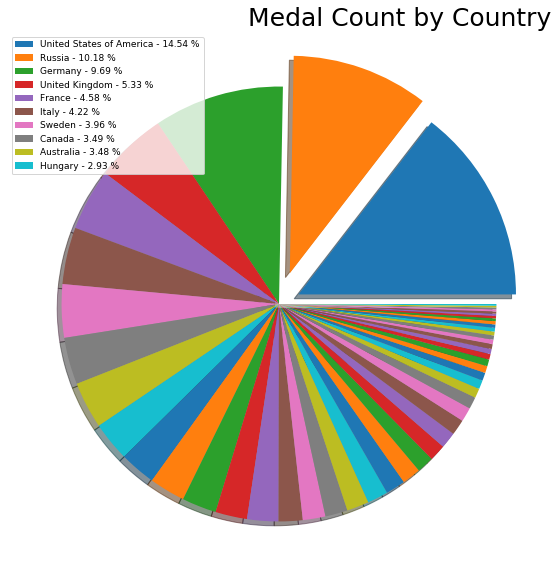

In [15]:
# Pie chart of the total medals tally
values = countryMedalTally.iloc[0:50,]["MedalCount"]
labels = countryMedalTally.iloc[0:50,]["Region"]
percents = 100*values/values.sum()
labels_percents = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels,percents)]

# Creating the explode to emphasize the US and Russia
explode = [0,]*len(labels)
explode[0]=0.1
explode[1]=0.15

plt.figure(figsize=(15,10))
plt.pie(values, labels=None, explode=explode, shadow=True)
plt.title("Medal Count by Country", fontsize=25, loc='right')
plt.legend(labels=labels_percents[:10], fontsize=9, loc='upper left')

plt.savefig("pngs/1 - Country Share of all Medals.png")

plt.show()

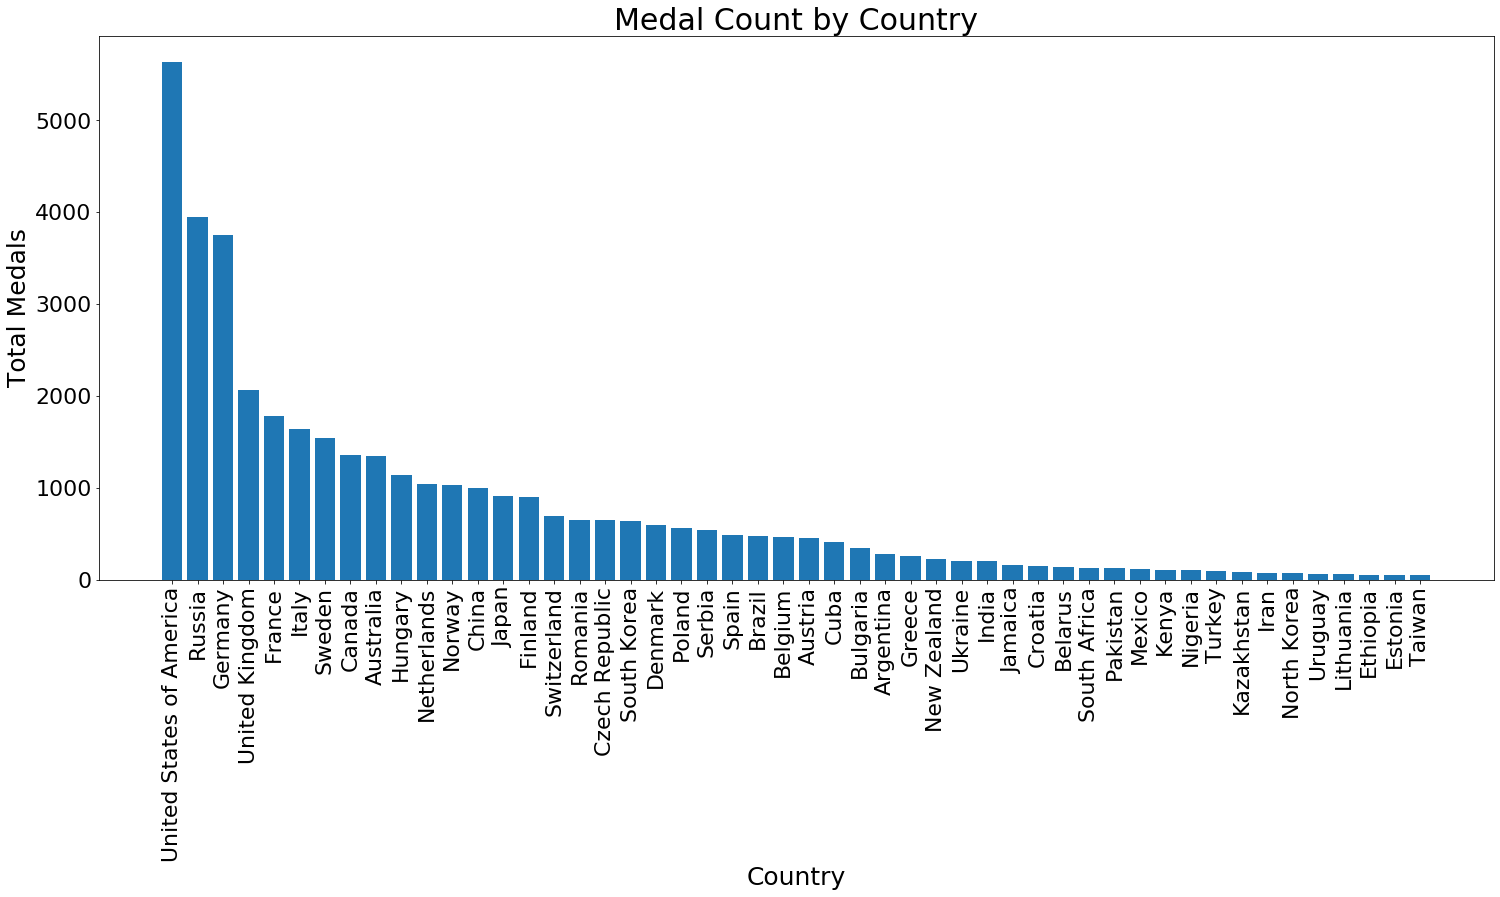

In [16]:
# If we would like to see all countries, here is a bar chart of total medals tally

x_values=countryMedalTally.iloc[0:50,]["Region"]
y_values=countryMedalTally.iloc[0:50,]["MedalCount"]

plt.figure(figsize=(25,10))
plt.bar(x_values,y_values)
plt.title("Medal Count by Country", fontsize=30)
plt.xlabel("Country", fontsize=25)
plt.ylabel("Total Medals", fontsize=25)
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=22)

plt.show()

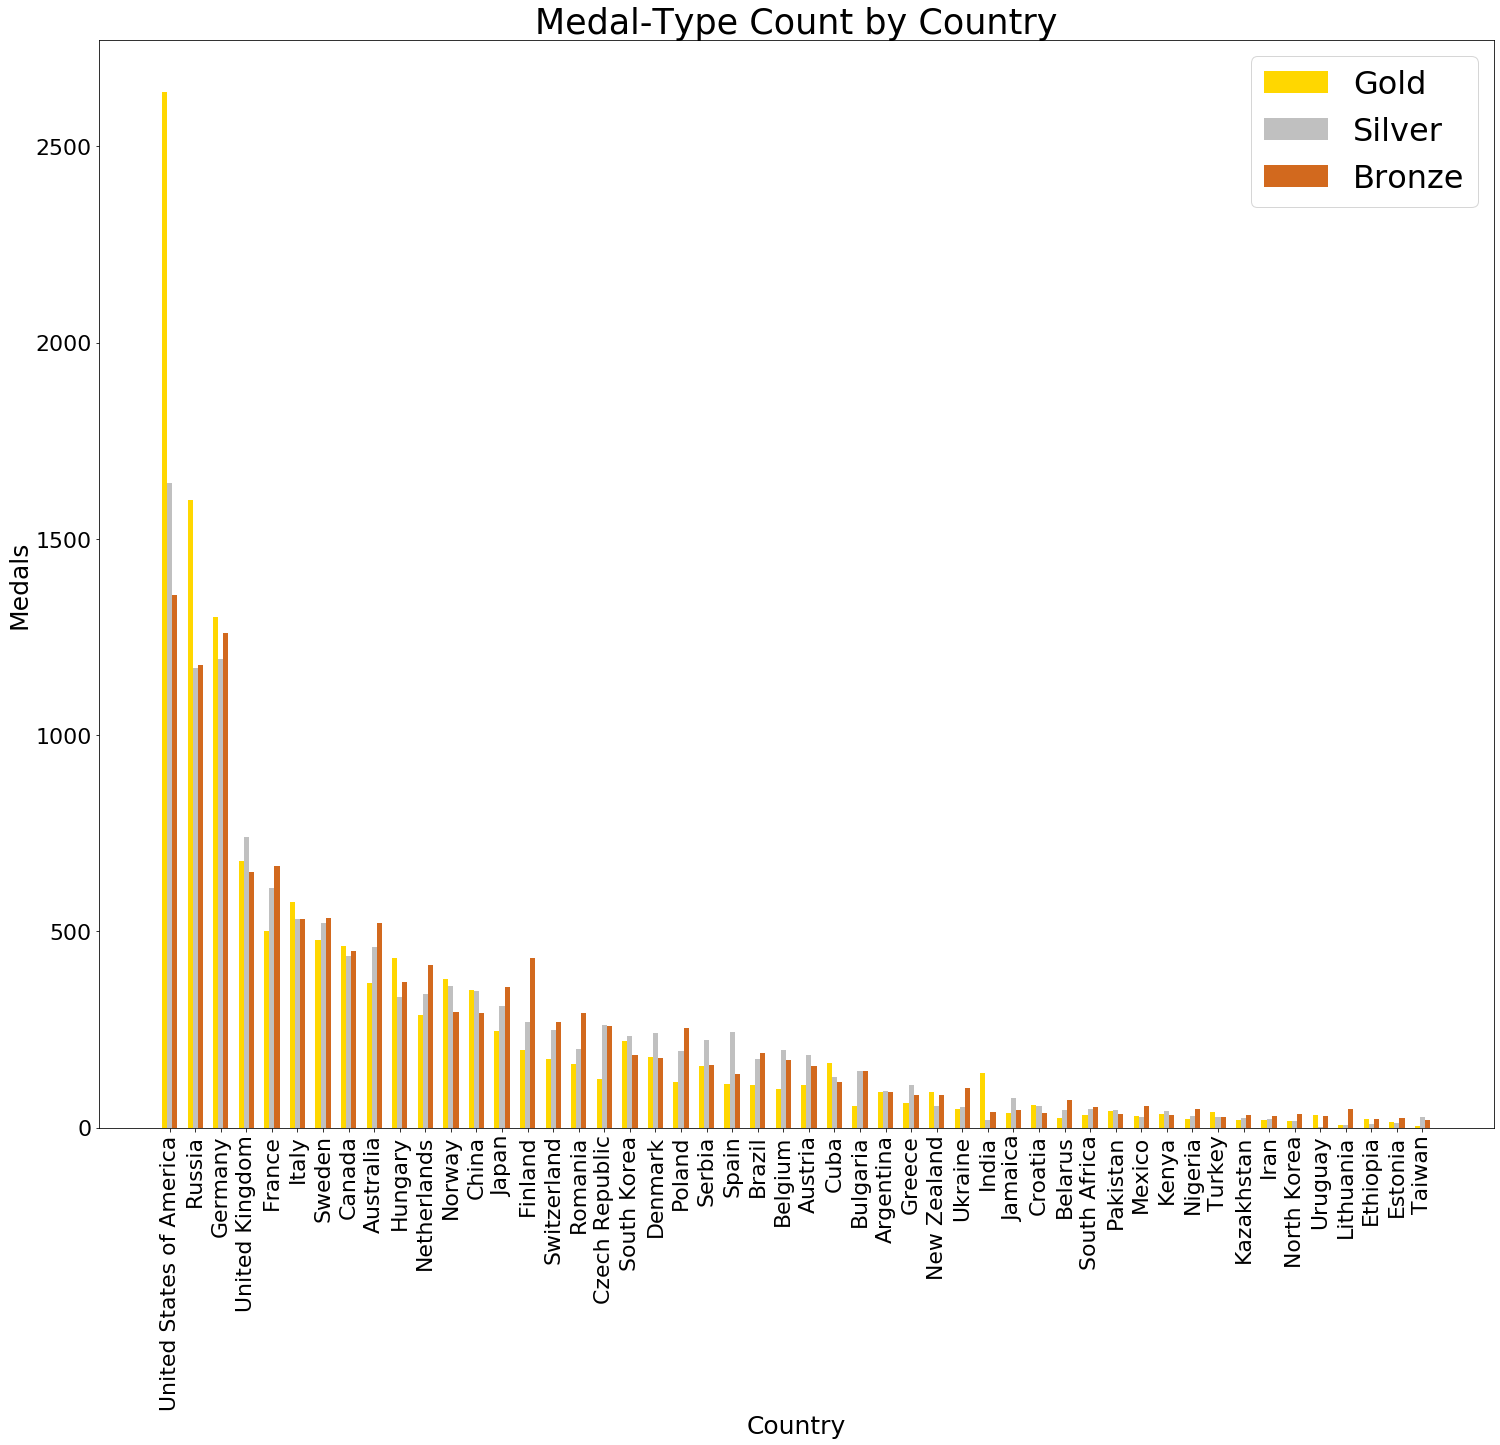

In [18]:
# Breakdown of Medals by Country

#define x-values as numbers from 0 to 49
labels=list(countryMedalTally.iloc[0:50,]["Region"])
x_values=np.arange(len(labels))

#define 3 y-values, 1 for each type of medal
y1_values=countryMedalTally.iloc[0:50,]["Gold"]
y2_values=countryMedalTally.iloc[0:50,]["Silver"]
y3_values=countryMedalTally.iloc[0:50,]["Bronze"]

#plot the 3 bars next to each other
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(111)
golds=ax.bar(x_values-0.2,y1_values,color="gold",align="center",width=0.2,label="Gold")
silvers=ax.bar(x_values,y2_values,color="silver",align="center",width=0.2,label="Silver")
bronzes=ax.bar(x_values+0.2,y3_values,color="chocolate",align="center",width=0.2,label="Bronze")

#set overall labels for the X and Y axes
ax.set_ylabel("Medals", fontsize=25)
ax.set_xlabel("Country", fontsize=25)

#arrange xticks and give them country labels
ax.set_xticks(x_values)
ax.set_xticklabels(labels)

#add legend
ax.legend(fontsize=32)

#for the overall figure, add a title, rotate the xticks
plt.title("Medal-Type Count by Country", fontsize=35)
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=22)

#save and show

plt.savefig("pngs/2 - Performance by Medal-Type for Top 50 Countries.png")

plt.show()

#### Heatmap of Top Performing Countries

In [21]:
#find center lats and lngs for every country#### Data Manipulation
countries=list(countryMedalTally["Region"])
center_lat=[None]*len(countries)
center_lng=[None]*len(countries)

gm = googlemaps.Client(key=gkey)

for i in range(len(countries)):
    try:
        geocode_result = gm.geocode(countries[i])[0]
        center_lat[i]=geocode_result['geometry']['location']['lat']
        center_lng[i]=geocode_result['geometry']['location']['lng']
    except:
        continue

In [22]:
#re-assign NaN lats and lngs to 0s
for i in range(len(center_lat)):
    if pd.isnull(center_lat[i]):
        center_lat[i]=0
        center_lng[i]=0

In [23]:
#create locations dataframe for the gmaps heat layer
locations=pd.DataFrame({
    "Lat":center_lat,
    "Lng":center_lng
})

locations.head()

,Lat,Lng
0,37.090240,-95.712891
1,61.524010,105.318756
2,51.165691,10.451526
3,55.378051,-3.435973
4,46.227638,2.213749


In [24]:
#configure gmaps
gmaps.configure(api_key=gkey)

#calculate medal weights
medalweights=list((3*countryMedalTally["Gold"])+(2*countryMedalTally["Silver"])+(countryMedalTally["Bronze"]))

#add heat layer
fig=gmaps.figure(zoom_level=2,center=(20,0))
heat_layer=gmaps.heatmap_layer(locations,weights=medalweights,dissipating=False,point_radius=5,max_intensity=1000)
fig.add_layer(heat_layer)

#save and display

display(fig)

Figure(layout=FigureLayout(height='420px'))

<Figure size 432x288 with 0 Axes>

---
## 2.2 Historical Performance by Country <br> <font size=2 color=lightgrey>by Amber</font>

#### Data Manipulation

In [25]:
# Let's look at just the top 10 regions' total medal counts
cleaned_byregion = olympicsMedals[['Region','MedalCount']]

cleaned_byregion = cleaned_byregion.groupby('Region').sum().sort_values('MedalCount',ascending = False)
top_ten_medalcounts = cleaned_byregion.iloc[0:10,].reset_index()
top_ten_regions = pd.DataFrame(top_ten_medalcounts['Region'])
top_ten_regions['Total Medal Count'] = countryMedalTally['MedalCount']
top_ten_regions

,Region,Total Medal Count
0,United States of America,5637
1,Russia,3947
2,Germany,3756
3,United Kingdom,2068
4,France,1777
5,Italy,1637
6,Sweden,1536
7,Canada,1352
8,Australia,1349
9,Hungary,1135


In [26]:
# Now we would like the total medal counts over time
overtime_byregion = olympicsMedals[['Region','Year','MedalCount']].reset_index(drop=True).dropna()
overtime_pivot = pd.pivot_table(overtime_byregion, values='MedalCount', index=['Region'],
                     columns=['Year'], aggfunc=np.sum,fill_value=0).reset_index()
medals_overtime = pd.merge(overtime_pivot, top_ten_regions, how='right', on='Region').set_index('Region')
medals_overtime = medals_overtime.sort_values(by='Total Medal Count', ascending=False)
del medals_overtime['Total Medal Count']
medals_overtime.head(3)

,1896,1900,1904,1906,1908,1912,1920,1924,1928,1932,...,1998,2000,2002,2004,2006,2008,2010,2012,2014,2016
Region,,,,,,,,,,,,,,,,,,,,,
United States of America,20,63,394,24,65,107,194,194,102,223,...,34,242,84,263,52,317,97,248,64,264
Russia,0,0,0,0,3,14,0,0,0,0,...,52,187,38,189,41,142,25,140,68,115
Germany,32,45,16,30,21,53,0,0,82,57,...,44,118,61,149,54,99,54,94,36,159


In [27]:
#create dict of dataframes for count of male/female athletes over time for top 10 countries

overtime_bygender = olympicsMedals[['Region','Sex','Year','MedalCount']].reset_index(drop=True).dropna()

count = {}
bygender = {}

for region in medals_overtime.index:
    count[region] = overtime_bygender.loc[overtime_bygender['Region']==region].reset_index(drop=True).dropna()
    bygender[region] = pd.pivot_table(count[region], values='MedalCount', index=['Sex'], columns=['Year'], aggfunc=np.sum,fill_value=0).reset_index()
    bygender[region] = bygender[region].set_index('Sex')

In [28]:
# Gather a list of only the summer Olympic Games
summer_years = []
for i in range(len(medals_overtime.columns)):
    if medals_overtime.columns[i]%4==0:
        summer_years.append(medals_overtime.columns[i])

#### Plotting Historical Performance

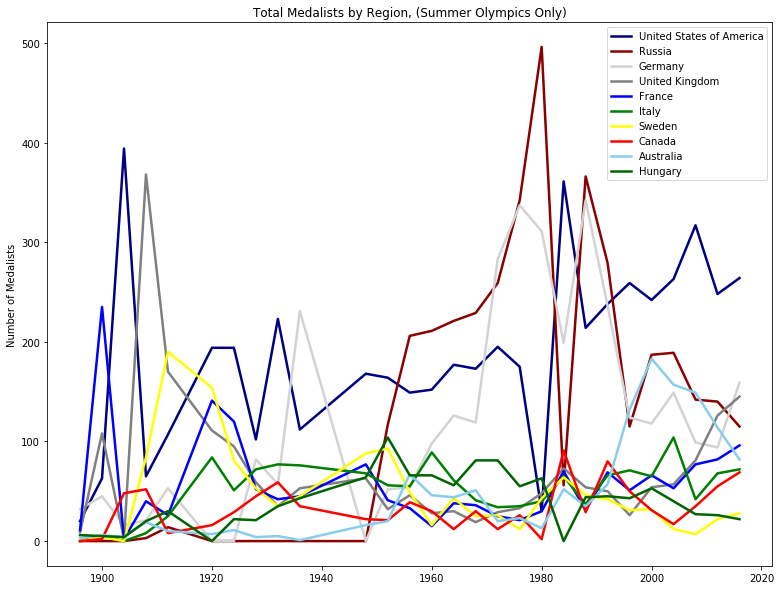

In [39]:
colors = ['navy','darkred','lightgrey','grey','blue','green','yellow','red','skyblue','darkgreen']
plt.figure(0,(13,10))

medals_overtime_summer = medals_overtime.loc[:,summer_years]
for i in range(len(medals_overtime_summer)):
    plt.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[i], '-', color=colors[i], lw=2.5, label = medals_overtime_summer.index[i])
plt.title('Total Medalists by Region, (Summer Olympics Only)')
plt.ylabel('Number of Medalists')
plt.legend(loc = 'best')

plt.savefig("pngs/4 - Summer Medals Over Time for the Top 10 Countries.png")

plt.show()

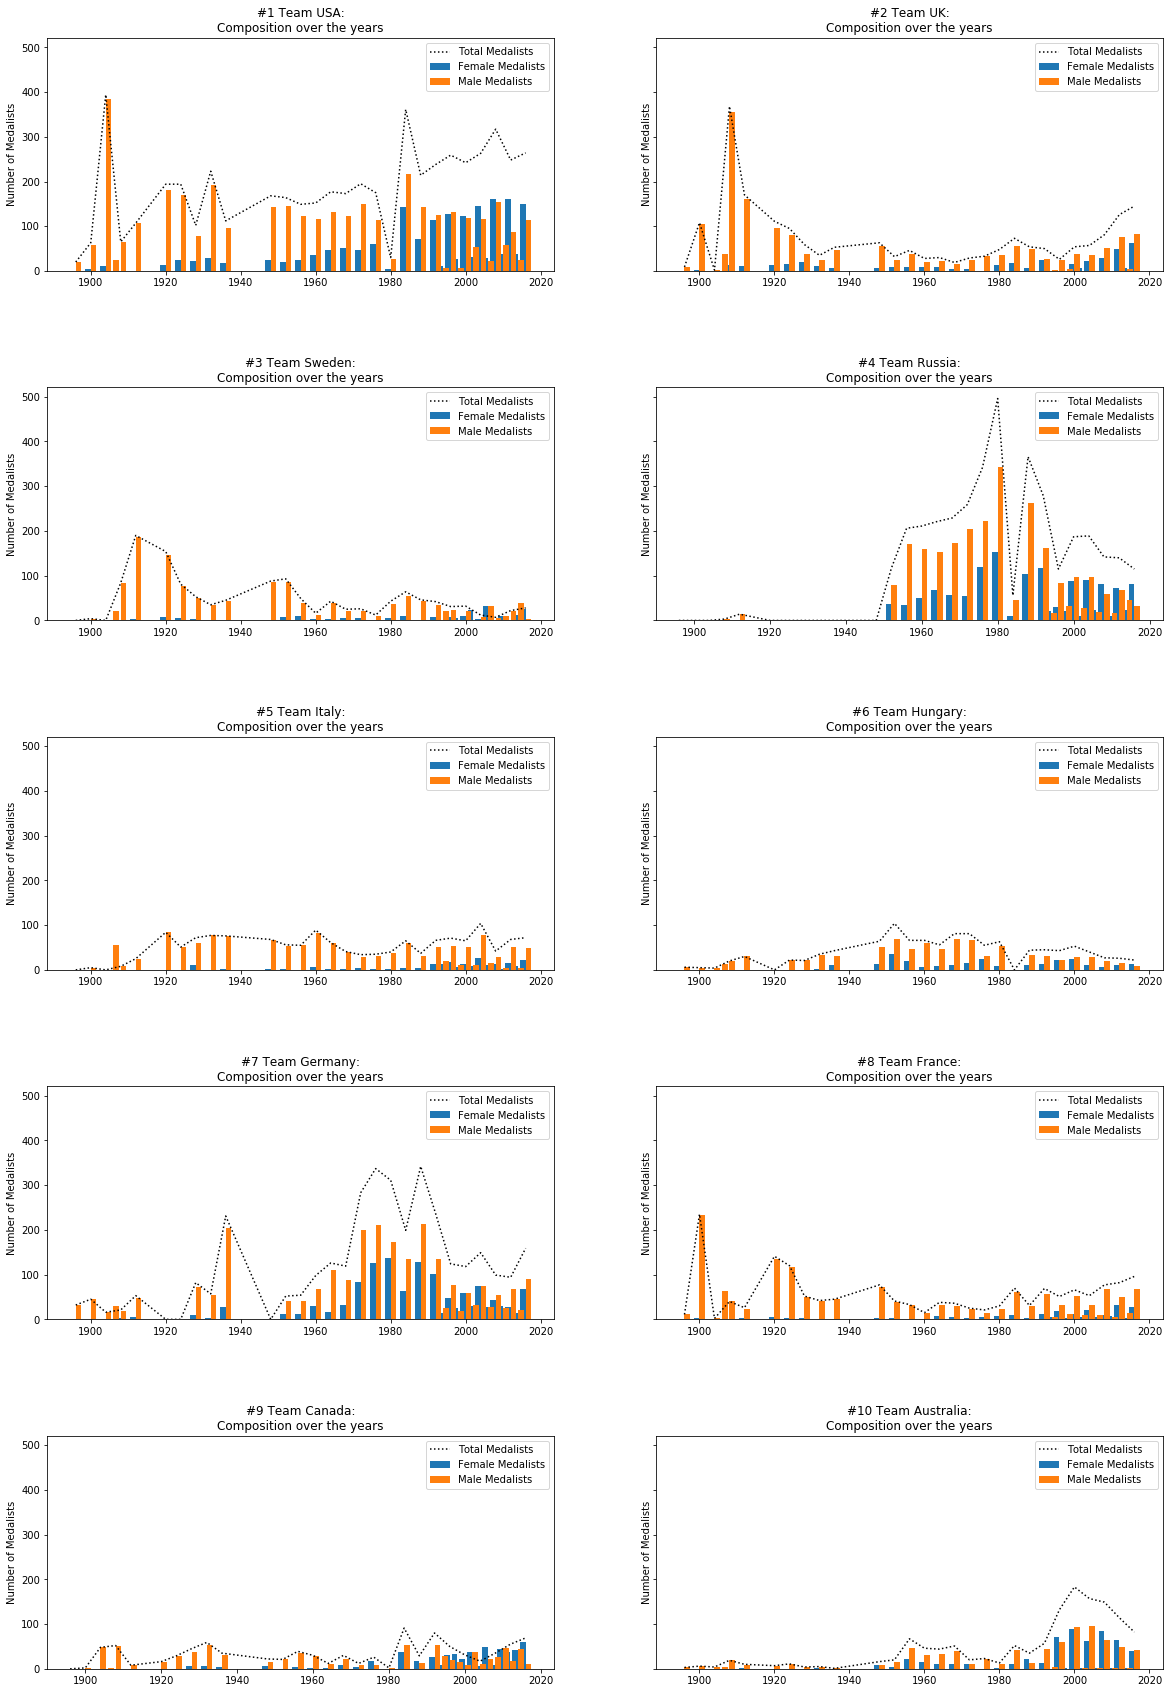

In [40]:
# Plot the values of male, female and total athletes using bar charts and the line charts.
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6) , (ax7,ax8), (ax9, ax10)) = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30), sharey = True)
fig.subplots_adjust(hspace = 0.5)

# Plot team #1 USA's performance by gender
ax1.bar(bygender['United States of America'].columns, bygender['United States of America'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax1.bar(bygender['United States of America'].columns, bygender['United States of America'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax1.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[0], linestyle = ':', color = 'black', label = 'Total Medalists')
ax1.set_title('#1 Team USA:\nComposition over the years')
ax1.set_ylabel('Number of Medalists')
ax1.legend(loc = 'best')

# Plot team #2 UK's performance by gender
ax2.bar(bygender['United Kingdom'].columns, bygender['United Kingdom'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax2.bar(bygender['United Kingdom'].columns, bygender['United Kingdom'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax2.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[3], linestyle = ':', color = 'black', label = 'Total Medalists')
ax2.set_title('#2 Team UK:\nComposition over the years')
ax2.set_ylabel('Number of Medalists')
ax2.legend(loc = 'best')

# Plot team #3 Sweden's performance by gender
ax3.bar(bygender['Sweden'].columns, bygender['Sweden'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax3.bar(bygender['Sweden'].columns, bygender['Sweden'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax3.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[6], linestyle = ':', color = 'black', label = 'Total Medalists')
ax3.set_title('#3 Team Sweden:\nComposition over the years')
ax3.set_ylabel('Number of Medalists')
ax3.legend(loc = 'best')

# Plot team #4 Russia's performance by gender
ax4.bar(bygender['Russia'].columns, bygender['Russia'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax4.bar(bygender['Russia'].columns, bygender['Russia'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax4.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[1], linestyle = ':', color = 'black', label = 'Total Medalists')
ax4.set_title('#4 Team Russia:\nComposition over the years')
ax4.set_ylabel('Number of Medalists')
ax4.legend(loc = 'best')

# Plot team #5 Italy's performance by gender
ax5.bar(bygender['Italy'].columns, bygender['Italy'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax5.bar(bygender['Italy'].columns, bygender['Italy'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax5.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[5], linestyle = ':', color = 'black', label = 'Total Medalists')
ax5.set_title('#5 Team Italy:\nComposition over the years')
ax5.set_ylabel('Number of Medalists')
ax5.legend(loc = 'best')

# Plot team #6 Hungary's performance by gender
ax6.bar(bygender['Hungary'].columns, bygender['Hungary'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax6.bar(bygender['Hungary'].columns, bygender['Hungary'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax6.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[9], linestyle = ':', color = 'black', label = 'Total Medalists')
ax6.set_title('#6 Team Hungary:\nComposition over the years')
ax6.set_ylabel('Number of Medalists')
ax6.legend(loc = 'best')

# Plot team #7 Germany's performance by gender
ax7.bar(bygender['Germany'].columns, bygender['Germany'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax7.bar(bygender['Germany'].columns, bygender['Germany'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax7.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[2], linestyle = ':', color = 'black', label = 'Total Medalists')
ax7.set_title('#7 Team Germany:\nComposition over the years')
ax7.set_ylabel('Number of Medalists')
ax7.legend(loc = 'best')

# Plot team #8 France's performance by gender
ax8.bar(bygender['France'].columns, bygender['France'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax8.bar(bygender['France'].columns, bygender['France'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax8.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[4], linestyle = ':', color = 'black', label = 'Total Medalists')
ax8.set_title('#8 Team France:\nComposition over the years')
ax8.set_ylabel('Number of Medalists')
ax8.legend(loc = 'best')

# Plot team #9 Canada's performance by gender
ax9.bar(bygender['Canada'].columns, bygender['Canada'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax9.bar(bygender['Canada'].columns, bygender['Canada'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax9.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[7], linestyle = ':', color = 'black', label = 'Total Medalists')
ax9.set_title('#9 Team Canada:\nComposition over the years')
ax9.set_ylabel('Number of Medalists')
ax9.legend(loc = 'best')

# Plot team #10 Australia's performance by gender
ax10.bar(bygender['Australia'].columns, bygender['Australia'].iloc[0], width = -1.5, align = 'edge', label = 'Female Medalists')
ax10.bar(bygender['Australia'].columns, bygender['Australia'].iloc[1], width = 1.5, align = 'edge', label = 'Male Medalists')
ax10.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[8], linestyle = ':', color = 'black', label = 'Total Medalists')
ax10.set_title('#10 Team Australia:\nComposition over the years')
ax10.set_ylabel('Number of Medalists')
ax10.legend(loc = 'best')

plt.show()

# 3. What are some factors that may impact a country's Olympic success?

## <font color=green>**Wealth**</font>  $\;\;\;\;\;$ |  $\;\;\;\;\;$ <font color=red>**Health**</font> $\;\;\;\;\;$ | $\;\;\;\;\;$ <font color=gold>**Happiness**</font> $\;\;\;\;\;$ | $\;\;\;\;\;$ <font color=darkorchid>**Liberty**</font> $\;\;\;\;\;$ | $\;\;\;\;\;$ <font color=deepskyblue>**Environment**</font>

---
## 3.1 <font color=green>Wealth</font>: <font size=4>Correlation between GDP and Performance</font> <br> <font size=2 color=lightgrey>by Warren</font>

#### Data Cleaning and Manipulation

In [31]:
# Read CSV into Pandas DataFrame for both GDP and GDP per Capita data
raw_GDP_df = pd.read_csv('raw_data/CLEAN-GDPcurrent-USD-countries.csv')
raw_GDPpC_df = pd.read_csv('raw_data/CLEAN-GDPPC-USD-countries.csv')

#> raw_GDP_df.head(17)

In [32]:
# We do not need the Country ID, and we recall that our term for 
#  countries in the previous dataframes is 'Region'
raw_GDP_df = raw_GDP_df.drop(columns=['CountryID'])
raw_GDP_df = raw_GDP_df.rename(columns={'Country': 'Region'})

raw_GDPpC_df = raw_GDPpC_df.drop(columns=['CountryID'])
raw_GDPpC_df = raw_GDPpC_df.rename(columns={'Country': 'Region'})

#> raw_GDP_df.head(17)

In [33]:
# We only care about GDP and since it is always the largest figure for
#  each country, we can simply group by Region and use .max() 
#   to keep the GDP figures

GDP_groupedby_Region = raw_GDP_df.groupby('Region')
GDP_df = pd.DataFrame(GDP_groupedby_Region.max())
GDP_df = GDP_df.reset_index()
GDPpC_df = raw_GDPpC_df # no need to group the GDPpC data because there is only one row per country

#> GDP_df

# Given that there are only 195 countries but we have 221 Rows,
#  we know that some of these countries no longer exist. Luckily, 
#   they will be sorted out when we merge into the Olympic countries list

In [34]:
# Because we don't have GDP data dating back to the early 1900's like
#  we do Olympics data, we will just focus on the most recent Games

# Create a new df for each 
recent_GDP_df = GDP_df[['Region']]
recent_GDPpC_df = GDPpC_df[['Region']]

# Make a single column which has the average GDP figures surrounding the 
#  most recent Summer and Winter Olympic Games
recent_GDP_df['GDP'] = round(GDP_df[['2012','2013','2014',
                                       '2015','2016','2017',
                                       '2018']].mean(axis=1)/(10**9),3)

recent_GDPpC_df['GDPpC'] = round(GDPpC_df[['2012','2013','2014',
                                           '2015','2016','2017',
                                           '2018']].mean(axis=1),1)

recent_GDP_df # We can see that 'Former' countries have no new data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Region,GDP
0,Afghanistan,21.021
1,Albania,12.808
2,Algeria,185.714
3,Andorra,3.106
4,Angola,123.286
...,...,...
216,Yemen Democratic (Former),NaN
217,Yugoslavia (Former),NaN
218,Zambia,24.798
219,Zanzibar,1.281


In [35]:
# We will now merge the data with our previous medal count data
gender_medalled_GDP_df = pd.merge(
    gender_medalled_df, recent_GDP_df, 
    on='Region', how='left')

gender_medalled_GDP_df = pd.merge(
    gender_medalled_GDP_df, recent_GDPpC_df, 
    on='Region', how='left')

gender_medalled_GDP_df.head(3)

,Region,Medal_Females,Medal_Males,Medal_Total,Percent_Female,Percent_Male,GDP,GDPpC
0,Argentina,2.0,20.0,22.0,9.09,90.91,589.286,13694.3
1,Australia,41.0,44.0,85.0,48.24,51.76,1431.429,60014.9
2,Austria,9.0,20.0,29.0,31.03,68.97,418.857,48222.9


In [33]:
# Check to see if we have any Regions withough GDP data
gender_medalled_GDP_df.loc[gender_medalled_GDP_df.GDP.isnull() == True]

,Region,Medal_Females,Medal_Males,Medal_Total,Percent_Female,Percent_Male,GDP,GDPpC
60,Taiwan,5.0,0.0,5.0,100.0,0.0,NaN,NaN
75,Individual Olympic Athletes,0.0,2.0,2.0,0.0,100.0,NaN,NaN


In [36]:
# We only need to fix Taiwan's GDP values,
gender_medalled_GDP_df.set_value(60, 'GDP', 586.104)
gender_medalled_GDP_df.set_value(60, 'GDPpC', 24828.0)

# because obviously the Individual Olympic Athletes have no GDP
gender_medalled_GDP_df = gender_medalled_GDP_df.dropna()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


<font size=2> Source: [Economy_of_Taiwan](https://en.wikipedia.org/wiki/Economy_of_Taiwan)</font>

### Plotting Olympic Success versus Country Wealth

The correlation value (r) is: 0.7857557856599716


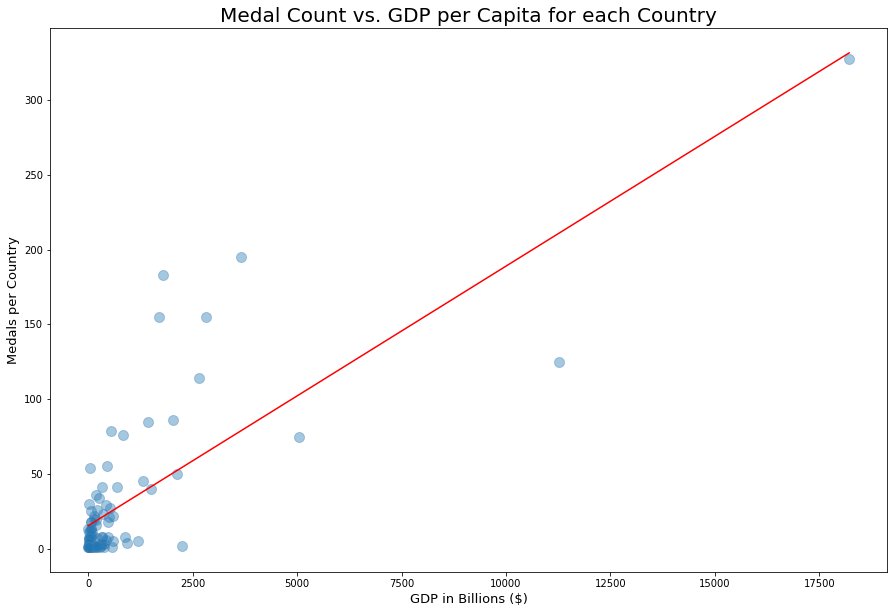

In [35]:
# Plot Country GDP versus Total Medal Count
x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total

# And create the regression line showing correlation
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.4)
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r-')
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
print(f"The correlation value (r) is: {rvalue}")

plt.savefig("Medals Over Time, split by Gender, for each of the Top 10 Countries.png")

plt.show()

The correlation value (r) is: 0.7857557856599716


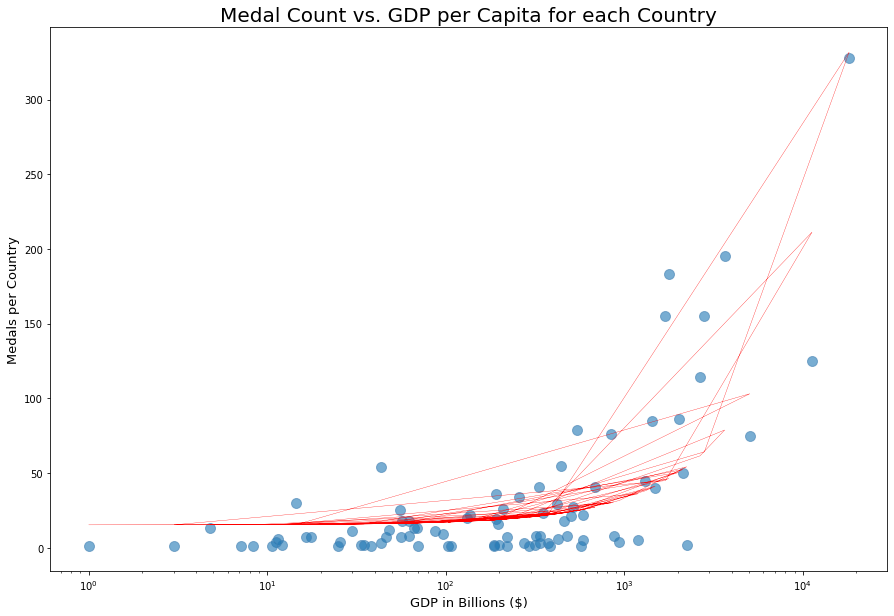

In [36]:
# The abover plot is a little difficult to see due to the clustering of values near the origin
# This is because the USA's GDP dwarfs most other countries'
# We can correct for thi by using log on the x-axis
x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.6)
plt.plot(x_values, regress_values, 'r-', lw=0.3)
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
plt.xscale('log')
print(f"The correlation value (r) is: {rvalue}")
plt.show()

The correlation value (r) is: 0.7857557856599716


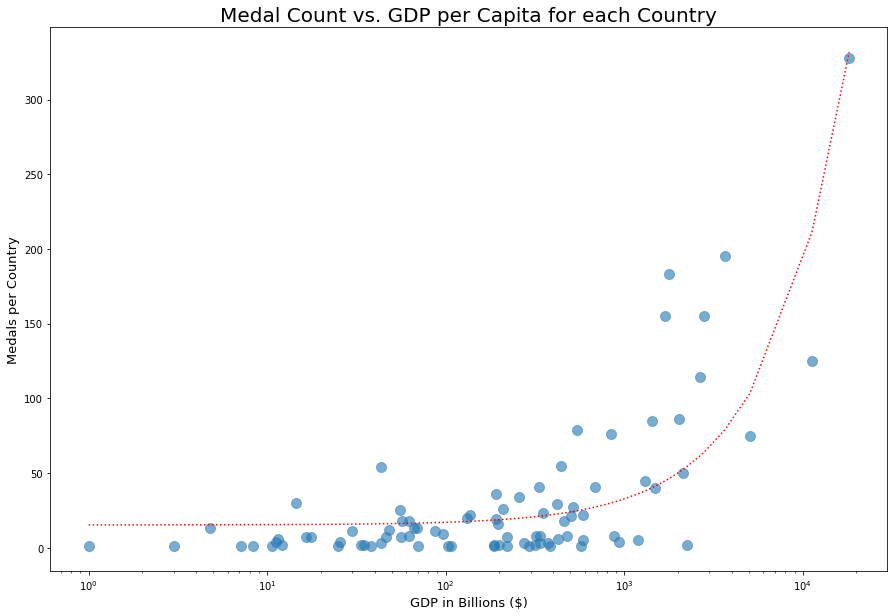

In [37]:
# I left the above in the presentation because it is a good example of how MatPlotLib.plot() actually works
# Because the regress_values are in no particular order (actually, they're in alphabetical order by country technically),
# the way plot works is that it simply connects the Nth value of (x,y) to the Nth+1 value
# We can combat this by sorting the (x,y) values as seen below
x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.6)
# Sort the (x,y) values to ensure a smooth regression curve on the log plot
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r:')
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
plt.xscale('log')
print(f"The correlation value (r) is: {rvalue}")
plt.show()

The correlation value (r) is 0.409 with a p-value of 9.21470829235482e-05


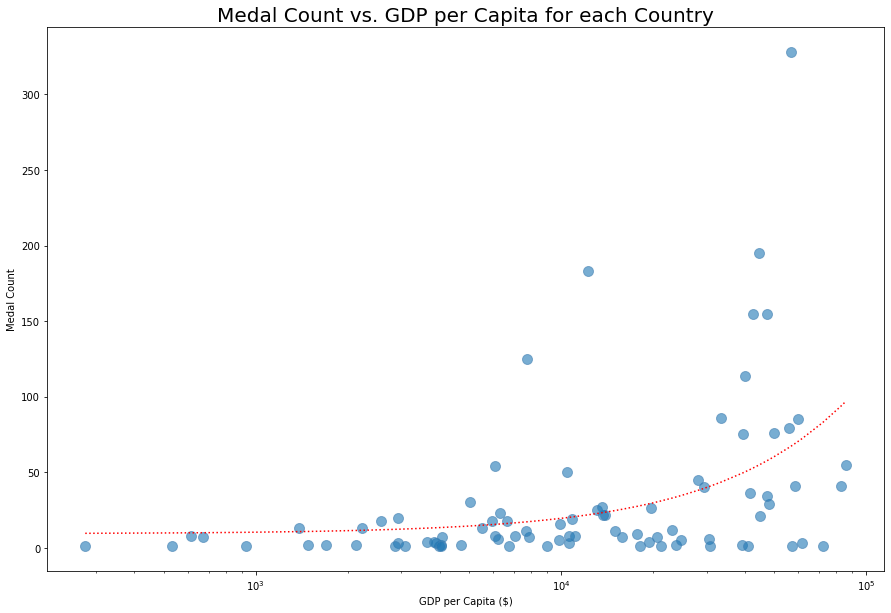

In [38]:
# Now let's check out Medal Count versus GDP per Capita
x_values = gender_medalled_GDP_df.GDPpC
y_values = gender_medalled_GDP_df.Medal_Total

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.6)
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r:')
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP per Capita ($)')
plt.ylabel('Medal Count')
plt.xscale('log')
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")
plt.show()

The correlation value (r) is 0.786 with a p-value of 3.2723006318153277e-19


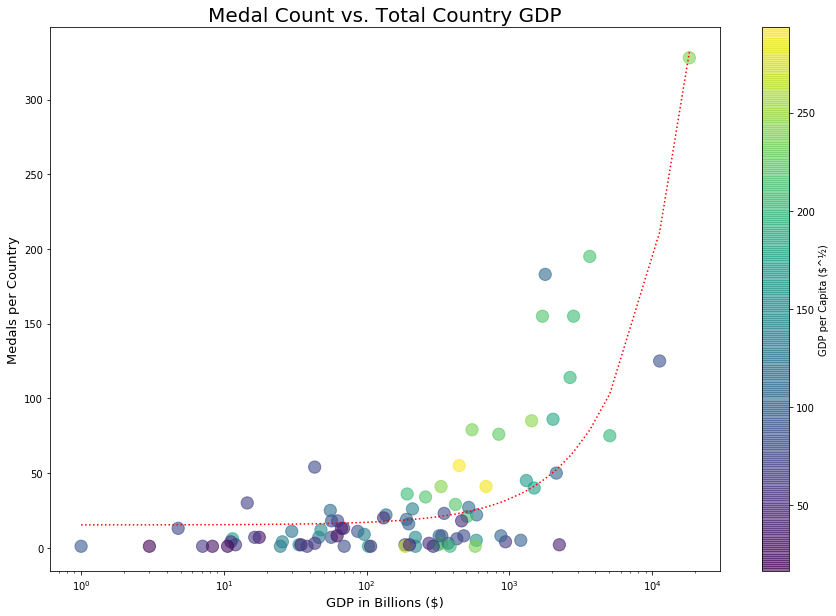

In [41]:
# Not as much of a correlation as before so we will stick to comparing the total GDP
# but we can add a colored z-axis for fun that shows GDP per Capita

x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total
z_values = gender_medalled_GDP_df.GDPpC

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, c=z_values**(1/2), s=150, alpha=.6)
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r:')
plt.title('Medal Count vs. Total Country GDP', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
plt.xscale('log')
plt.colorbar(label='GDP per Capita ($^½)')
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.savefig("pngs/5 - Medal Count vs GDP (per Capita as colorbar).png")

plt.show()

---
## 3.2 <font color=red>Health</font>: <font size=4>Correlation between Obesity Rates and Performance</font> <br> <font size=2 color=lightgrey>by Amber</font>

In [42]:
#data file
filepath = "raw_data/World Obesity Rate.csv"

WOR_df = pd.read_csv(filepath, engine='python')

WOR_df

,regions,gender,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,F,3.22,3.39,3.58,3.78,3.99,4.20,4.43,4.66,4.91,5.16,5.43,5.71,6.00,6.31,6.62,6.95,7.29,7.65
1,Afghanistan,M,1.10,1.17,1.25,1.34,1.43,1.52,1.62,1.73,1.84,1.96,2.09,2.22,2.36,2.52,2.68,2.85,3.03,3.22
2,Angola,F,5.34,5.63,5.94,6.25,6.58,6.93,7.29,7.66,8.04,8.44,8.85,9.27,9.70,10.15,10.61,11.09,11.57,12.07
3,Angola,M,1.32,1.41,1.51,1.62,1.73,1.85,1.98,2.12,2.26,2.42,2.58,2.76,2.94,3.14,3.34,3.56,3.80,4.05
4,Albania,F,14.34,14.67,15.02,15.40,15.79,16.20,16.62,17.06,17.51,17.98,18.45,18.92,19.40,19.88,20.36,20.84,21.33,21.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,South Africa,M,7.23,7.58,7.96,8.34,8.74,9.16,9.60,10.04,10.51,10.99,11.48,11.99,12.51,13.04,13.59,14.16,14.75,15.35
374,Zambia,F,6.54,6.72,6.93,7.17,7.43,7.71,8.01,8.34,8.68,9.05,9.42,9.82,10.22,10.64,11.06,11.51,11.96,12.43
375,Zambia,M,1.58,1.63,1.69,1.75,1.83,1.91,2.00,2.10,2.21,2.33,2.45,2.59,2.73,2.88,3.03,3.20,3.38,3.56
376,Zimbabwe,F,17.51,18.02,18.51,18.99,19.47,19.94,20.40,20.85,21.30,21.74,22.17,22.60,23.03,23.47,23.91,24.35,24.80,25.26


In [43]:
# Choosing the recent years
col = WOR_df.loc[: , "2012":"2016"]
WOR_df['Recent Avg. Obesity Rate'] = col.mean(axis=1)
recent_WOR_df = WOR_df[['regions','gender','Recent Avg. Obesity Rate']]
recent_WOR_df =recent_WOR_df.rename(columns={"regions": "Region", "gender":'Sex'})
recent_WOR_df

,Region,Sex,Recent Avg. Obesity Rate
0,Afghanistan,F,6.964
1,Afghanistan,M,2.860
2,Angola,F,11.098
3,Angola,M,3.578
4,Albania,F,20.842
...,...,...,...
373,South Africa,M,14.178
374,Zambia,F,11.520
375,Zambia,M,3.210
376,Zimbabwe,F,24.358


In [44]:
#limit data to show only 2012 + 2016 values
cleaned_olympicsMedals = olympicsMedals[['Region','Year','Sex','MedalCount']].reset_index(drop=True)
cleaned_olympicsMedals = cleaned_olympicsMedals.loc[cleaned_olympicsMedals["Year"] > 2011]
grouped_olympicMedals = cleaned_olympicsMedals.groupby(['Region','Sex']).sum().reset_index()
del grouped_olympicMedals['Year']
grouped_olympicMedals= grouped_olympicMedals.sort_values('MedalCount')
grouped_olympicMedals

,Region,Sex,MedalCount
0,Afghanistan,F,0
247,Myanmar,F,0
246,Mozambique,M,0
245,Mozambique,F,0
243,Morocco,F,0
...,...,...,...
383,United Kingdom,M,162
298,Russia,F,177
132,Germany,M,180
385,United States of America,M,228


In [45]:
WOR_merged = pd.merge(
    recent_WOR_df, grouped_olympicMedals, 
    how='outer', on=['Region','Sex']).reset_index(drop=True).dropna()
WOR_F = WOR_merged[WOR_merged['Sex'] == "F"]
WOR_M = WOR_merged[WOR_merged['Sex'] == "M"]
WOR_merged

,Region,Sex,Recent Avg. Obesity Rate,MedalCount
0,Afghanistan,F,6.964,0.0
1,Afghanistan,M,2.860,1.0
2,Angola,F,11.098,0.0
3,Angola,M,3.578,0.0
4,Albania,F,20.842,0.0
...,...,...,...,...
373,South Africa,M,14.178,28.0
374,Zambia,F,11.520,0.0
375,Zambia,M,3.210,0.0
376,Zimbabwe,F,24.358,0.0


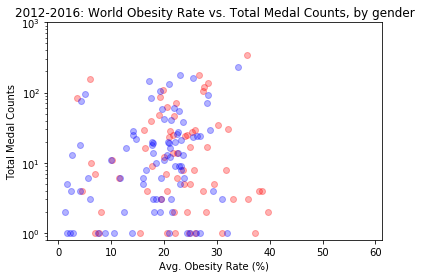

In [46]:
plt.scatter(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'], facecolors = 'red', alpha=0.3)

x_values = pd.to_numeric(WOR_M['Recent Avg. Obesity Rate']).astype(float)
y_values = pd.to_numeric(WOR_M['MedalCount']).astype(float)

plt.scatter(x_values,y_values,facecolors="blue", alpha=0.3)
plt.yscale('log')
plt.ylim(0.8,1000)
plt.xlabel('Avg. Obesity Rate (%)')
plt.ylabel('Total Medal Counts')
plt.title('2012-2016: World Obesity Rate vs. Total Medal Counts, by gender')

plt.savefig("pngs/6 - Recent World Obesity Rate vs Total Medal Counts, by gender.png")

plt.show()

In [47]:
coefficient_female=stats.pearsonr(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'])[0]
pvalue_female=stats.pearsonr(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'])[1]
print(f"The correlation for female is {round(coefficient_female,4)} and the p-value is {round(pvalue_female,4)}")

coefficient_male=stats.pearsonr(WOR_M['Recent Avg. Obesity Rate'],WOR_M['MedalCount'])[0]
pvalue_male=stats.pearsonr(WOR_M['Recent Avg. Obesity Rate'],WOR_M['MedalCount'])[1]
print(f"The correlation for male is {round(coefficient_male,4)} and the p-value is {round(pvalue_male,4)}")

The correlation for female is 0.0506 and the p-value is 0.5123
The correlation for male is 0.2224 and the p-value is 0.0036


---
## 3.3 <font color=gold>Happiness</font>: <font size=4>Correlation between Happiness and Performance</font> <br> <font size=2 color=lightgrey>by Amber</font>

In [48]:
#data file

filepath="raw_data/Happiness_Index (2015 -2019).csv"

happiness_df=pd.read_csv(filepath)

happiness_df.tail(20)

,Year,Overall rank,Country or region,Happiness Score,GDP per capita
762,2015,139,Congo (Brazzaville),3.989,0.67866
763,2015,140,Comoros,3.956,0.23906
764,2015,141,Uganda,3.931,0.21102
765,2015,142,Senegal,3.904,0.36498
766,2015,143,Gabon,3.896,1.06024
767,2015,144,Niger,3.845,0.06940
768,2015,145,Cambodia,3.819,0.46038
769,2015,146,Tanzania,3.781,0.28520
770,2015,147,Madagascar,3.681,0.20824
771,2015,148,Central African Republic,3.678,0.07850


In [49]:
#choose recent happiness score
happiness2016 = happiness_df.loc[happiness_df['Year']==2016].reset_index(drop = True)
del happiness2016['Year']
happiness2016 =happiness2016.rename(columns={"Country or region": "Region"})

In [50]:
#creating dataframe
medals2016 = pd.DataFrame(overtime_pivot[overtime_pivot.columns[[0,35]]])
medals2016['2016 % Share of Medals'] = medals2016[2016]/medals2016[2016].sum()
medals2016['2016 % Share of Medals'] = round(medals2016['2016 % Share of Medals'].mul(100).astype(float),2)
medals2016=medals2016.sort_values('2016 % Share of Medals', ascending = False)
medals2016=medals2016.rename(columns={"2016": "2016 Medals"})
medals2016

Year,Region,2016,2016 % Share of Medals
194,United States of America,264,13.06
67,Germany,159,7.86
193,United Kingdom,145,7.17
151,Russia,115,5.69
39,China,113,5.59
...,...,...,...
98,Laos,0,0.00
99,Latvia,0,0.00
100,Lebanon,0,0.00
101,Lesotho,0,0.00


In [51]:
#Exclude countries that haven't won any medals
happiness_merged_df = pd.merge(happiness2016, medals2016, how='outer', on='Region').reset_index(drop=True).dropna()
happiness_no_zeros_df = happiness_merged_df.loc[happiness_merged_df["2016 % Share of Medals"] > 0.0]
happiness_no_zeros_df.round(1)

,Overall rank,Region,Happiness Score,GDP per capita,2016,2016 % Share of Medals
0,1.0,Denmark,7.5,1.4,41.0,2.0
1,2.0,Switzerland,7.5,1.5,11.0,0.5
3,4.0,Norway,7.5,1.6,19.0,0.9
4,5.0,Finland,7.4,1.4,1.0,0.0
5,6.0,Canada,7.4,1.4,69.0,3.4
...,...,...,...,...,...,...
125,126.0,Georgia,4.3,0.8,7.0,0.4
128,129.0,Bulgaria,4.2,1.1,7.0,0.4
138,139.0,Ivory Coast,3.9,0.6,2.0,0.1
141,142.0,Niger,3.9,0.1,1.0,0.0


The correlation value (r) is: 0.3149022570834088


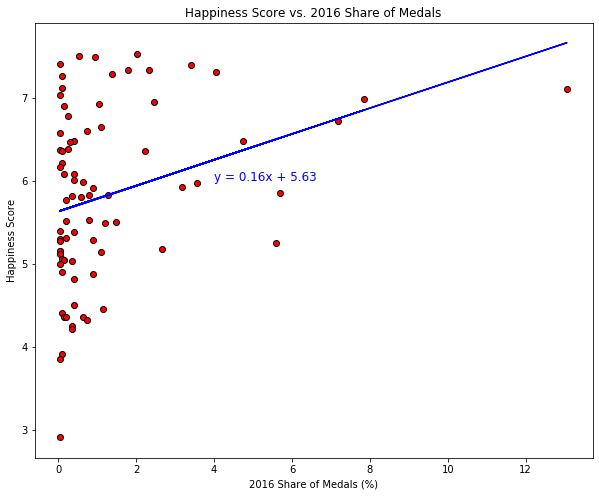

In [52]:
#plotting medals versus happiness
cleaned_happiness_merged = happiness_no_zeros_df[['Region','Happiness Score','GDP per capita','2016 % Share of Medals']].reset_index(drop=True)

x_values = pd.to_numeric(cleaned_happiness_merged['2016 % Share of Medals']).astype(float)
y_values = pd.to_numeric(cleaned_happiness_merged['Happiness Score']).astype(float)

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(10,8))
plt.scatter(x_values,y_values,facecolors="red", edgecolors="black")
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(4,6),fontsize=12,color="blue")
plt.xlabel('2016 Share of Medals (%)')
plt.ylabel('Happiness Score')
plt.title('Happiness Score vs. 2016 Share of Medals')
print(f"The correlation value (r) is: {rvalue}")

plt.savefig("pngs/7 - 2015 Happiness Score vs 2016 Share of Medals.png")

plt.show()

In [53]:
################################################
coefficient_female=stats.pearsonr(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'])[0]
pvalue_female=stats.pearsonr(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'])[1]
print(f"The correlation for female is {round(coefficient_female,4)} and the p-value is {round(pvalue_female,4)}")

coefficient_male=stats.pearsonr(WOR_M['Recent Avg. Obesity Rate'],WOR_M['MedalCount'])[0]
pvalue_male=stats.pearsonr(WOR_M['Recent Avg. Obesity Rate'],WOR_M['MedalCount'])[1]
print(f"The correlation for male is {round(coefficient_male,4)} and the p-value is {round(pvalue_male,4)}")

The correlation for female is 0.0506 and the p-value is 0.5123
The correlation for male is 0.2224 and the p-value is 0.0036


---
## 3.4 <font color=mediumorchid>Liberty</font>: <font size=4>Correlation between Women's Freedom and Performance</font> <br> <font size=2 color=lightgrey>by Warren</font>

#### Data Cleaning and Manipulation

In [54]:
# Read CSV into Pandas DataFrame
raw_WPS_df = pd.read_csv('raw_data/WPS_Index_Raw_Data.csv')
WPS_df = raw_WPS_df[[
 'WPS Index rank',
 'Country and group',
 'WPS Index value']]
WPS_df = WPS_df.rename(columns={'Country and group': 'Region'})

#>WPS_df

In [55]:
medalled_WPS_df = pd.merge(medalled_recent_df, WPS_df, on='Region', how='left')
medalled_WPS_df.count()

Name               2620
Sex                2620
Age                2620
Region             2620
Medal              2620
Sport              2620
Event              2620
Year               2620
Season             2620
WPS Index rank     2586
WPS Index value    2586
dtype: int64

In [56]:
print("Unfortunately the following countries don't have WPS scores:")
list(medalled_WPS_df.loc[medalled_WPS_df['WPS Index rank'].isnull() == True].Region.unique())

Unfortunately the following countries don't have WPS scores:


['Cuba',
 'North Korea',
 'Bahamas',
 'Kosovo',
 'Individual Olympic Athletes',
 'Taiwan',
 'Grenada',
 'Puerto Rico']

In [57]:
print(f"Thankfully the above countries only account for {round(100*(medalled_WPS_df.Name.count()-medalled_WPS_df['WPS Index rank'].count())/medalled_WPS_df.Name.count(),1)}% of all medals.")

Thankfully the above countries only account for 1.3% of all medals.


In [58]:
# So we will drop off those countries
medalled_WPS_df = medalled_WPS_df.dropna()

medalled_WPS_df.count() # all counts should show 2586

Name               2586
Sex                2586
Age                2586
Region             2586
Medal              2586
Sport              2586
Event              2586
Year               2586
Season             2586
WPS Index rank     2586
WPS Index value    2586
dtype: int64

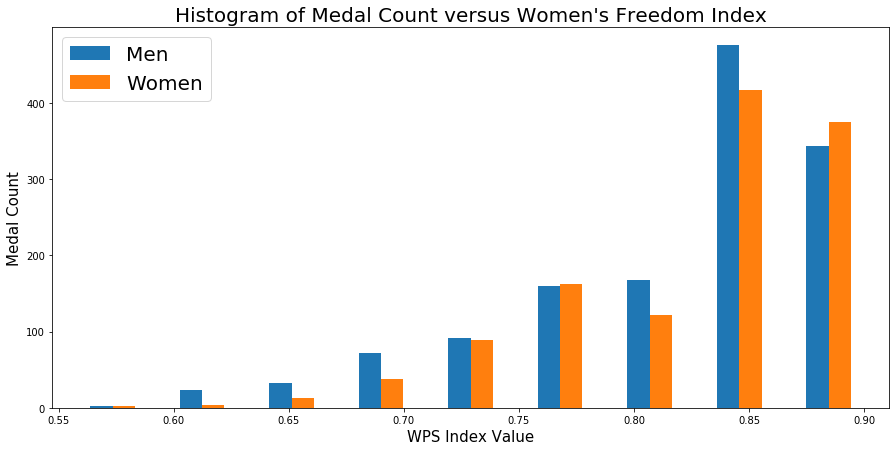

In [59]:
female_medalled_recent_WPS_df = medalled_WPS_df.loc[
    medalled_WPS_df.Sex == 'F']
male_medalled_recent_WPS_df = medalled_WPS_df.loc[
    medalled_WPS_df.Sex == 'M']

plt.figure(0,(15,7))
plt.hist([male_medalled_recent_WPS_df['WPS Index value'], 
          female_medalled_recent_WPS_df['WPS Index value']], 
         label=['Men', 'Women'], bins=9, rwidth=0.5)
plt.title("Histogram of Medal Count versus Women's Freedom Index", size=20)
plt.xlabel("WPS Index Value", size=15)
plt.ylabel("Medal Count", size=15)
plt.legend(fontsize=20, loc='upper left')
plt.show()

#### This histogram shows that countries in the 90th percentile of women's freedom see their female athletes bring home more metals than their male athletes. 
---

In [60]:
# Now let's add the WPS Index into the previously used df with GDP data
gender_medalled_GDP_WPS_df = pd.merge(
    gender_medalled_GDP_df, WPS_df, on='Region', how='left').dropna()

gender_medalled_GDP_WPS_df.count() # Should show 79 (86 medal-winning countries minus the 7 that don't have WPS scores)

Region             79
Medal_Females      79
Medal_Males        79
Medal_Total        79
Percent_Female     79
Percent_Male       79
GDP                79
GDPpC              79
WPS Index rank     79
WPS Index value    79
dtype: int64

The correlation value (r) is 0.106 with a p-value of 0.35238738958963656


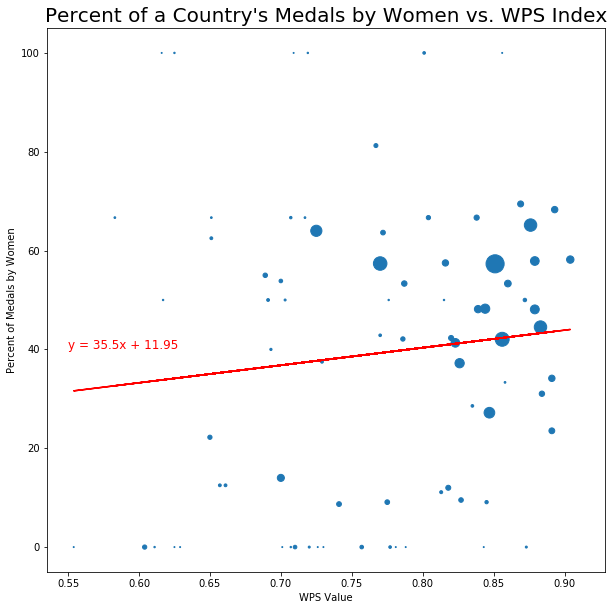

In [61]:
x_values = gender_medalled_GDP_WPS_df['WPS Index value']
y_values = gender_medalled_GDP_WPS_df['Percent_Female']
z_values = gender_medalled_GDP_WPS_df['Medal_Total']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(10,10))
plt.scatter(x_values, y_values, s=z_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.55,40),fontsize=12,color="red")
plt.title("Percent of a Country's Medals by Women vs. WPS Index", size=20)
plt.ylabel('Percent of Medals by Women')
plt.xlabel('WPS Value')
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.show()

The correlation value (r) is 0.37 with a p-value of 0.0007808976281852422


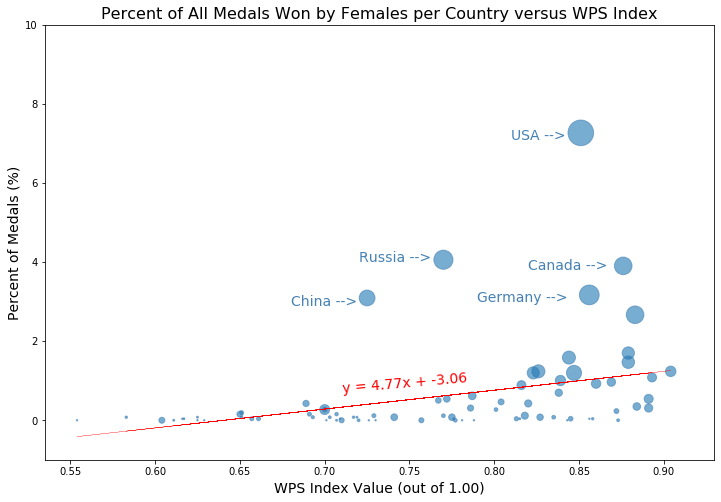

In [62]:
x_values = gender_medalled_GDP_WPS_df['WPS Index value']
y_values = 100*gender_medalled_GDP_WPS_df['Medal_Females']/gender_medalled_GDP_WPS_df.Medal_Total.sum()
z_values = gender_medalled_GDP_WPS_df['Medal_Total']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(12,8))
plt.scatter(x_values, y_values, s=z_values*2, edgecolor='steelblue', alpha=.6)
plt.plot(x_values,regress_values,"r-",lw=.2)
plt.annotate(line_eq,(.71,.7),fontsize=14,color="red", rotation=5)
plt.annotate('USA -->',(.81,7.1),fontsize=14,color="steelblue")
plt.annotate('Russia -->',(.72,4.0),fontsize=14,color="steelblue")
plt.annotate('Canada -->',(.82,3.8),fontsize=14,color="steelblue")
plt.annotate('Germany -->',(.79,3.0),fontsize=14,color="steelblue")
plt.annotate('China -->',(.68,2.9),fontsize=14,color="steelblue")
plt.title('Percent of All Medals Won by Females per Country versus WPS Index', size=16)
plt.xlabel('WPS Index Value (out of 1.00)', size=14)
plt.ylabel('Percent of Medals (%)', size=14)
plt.ylim(-1,10)
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.savefig("pngs/8 - Country Medal-Share of Female Medals vs WPS Index.png")

plt.show()

---
## 3.5 <font color=dodgerblue>Environment</font>: <font size=4>Correlation between Polution and Performance</font> <br> <font size=2 color=lightgrey>by Shashank</font>

In [63]:
#create the medal tally df for recent Olympic performance
recent_olympicsMedals_df = olympicsMedals.loc[olympics_df.Year >= 2014]

countrygroup=recent_olympicsMedals_df[["NOC", "Region", "MedalCount", "Gold", "Silver", "Bronze"]].groupby(by="Region")

pollution_df=pd.DataFrame(countrygroup.sum().sort_values(by="MedalCount",ascending=False)).reset_index()

pollution_df.head()

,Region,MedalCount,Gold,Silver,Bronze
0,United States of America,328,149,84,95
1,Germany,195,64,55,76
2,Russia,183,85,50,48
3,Canada,155,63,26,66
4,United Kingdom,155,65,59,31


In [64]:
# definition of 4 lists to get 4-corner bounds for each country
gm = googlemaps.Client(key=gkey)

lat1 = [None]*len(pollution_df.Region)
lat2 = [None]*len(pollution_df.Region)
lng1 = [None]*len(pollution_df.Region)
lng2 = [None]*len(pollution_df.Region)

for i in range(len(pollution_df.Region)):
    try:
        geocode_result = gm.geocode(pollution_df.Region[i])[0]
        lat1[i]=geocode_result["geometry"]["viewport"]["northeast"]["lat"]
        lat2[i]=geocode_result["geometry"]["viewport"]["southwest"]["lat"]
        lng1[i]=geocode_result["geometry"]["viewport"]["northeast"]["lng"]
        lng2[i]=geocode_result["geometry"]["viewport"]["southwest"]["lng"]
    except:
        continue

In [65]:
# Replace NaNs with 0's
for i in range(len(lat1)):
    if pd.isnull(lat1[i]):
        lat1[i]=0
        lat2[i]=0
        lng1[i]=0
        lng2[i]=0

In [66]:
#adding 4-corner bounds to our pollution_df
pollution_df["lat1"]=lat1
pollution_df["lng1"]=lng1
pollution_df["lat2"]=lat2
pollution_df["lng2"]=lng2

pollution_df.lat1=pollution_df.lat1.astype(str)
pollution_df.lng1=pollution_df.lng1.astype(str)
pollution_df.lat2=pollution_df.lat2.astype(str)
pollution_df.lng2=pollution_df.lng2.astype(str)

pollution_df.head()

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2
0,United States of America,328,149,84,95,49.38,-66.94,25.82,-124.39
1,Germany,195,64,55,76,55.0815,15.0418962,47.2701115,5.8663425
2,Russia,183,85,50,48,70.0,179.0,40.0,27.0
3,Canada,155,63,26,66,70.0,-50.0,42.0,-142.0
4,United Kingdom,155,65,59,31,61.5471111,9.5844157,47.5554486,-18.5319589


In [67]:
# creating the bounds column with API required formatting
pollution_df["bounds"]=pollution_df.lat1.str.cat(pollution_df.lng1,sep=",").str.cat(pollution_df.lat2,sep=",").str.cat(pollution_df.lng2,sep=",")

pollution_df.head()

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds
0,United States of America,328,149,84,95,49.38,-66.94,25.82,-124.39,"49.38,-66.94,25.82,-124.39"
1,Germany,195,64,55,76,55.0815,15.0418962,47.2701115,5.8663425,"55.0815,15.0418962,47.2701115,5.8663425"
2,Russia,183,85,50,48,70.0,179.0,40.0,27.0,"70.0,179.0,40.0,27.0"
3,Canada,155,63,26,66,70.0,-50.0,42.0,-142.0,"70.0,-50.0,42.0,-142.0"
4,United Kingdom,155,65,59,31,61.5471111,9.5844157,47.5554486,-18.5319589,"61.5471111,9.5844157,47.5554486,-18.5319589"


In [68]:
# request air quality data for all stations within the respective 4 bounds per country 
#  and calculate the average AQI level
url="https://api.waqi.info/map/bounds/"

avgPollution=[None]*len(pollution_df["bounds"])

for i in range(len(pollution_df["bounds"])):
    response=requests.get(url,params={"token":aqikey,"latlng":pollution_df["bounds"][i]}).json()
    numberOfStations=0
    totalaqi=0
    if len(response["data"])>0:
        for j in range(len(response["data"])):
            try:
                totalaqi+=int(response["data"][j]["aqi"])
                numberOfStations+=1
            except:
                continue
        if numberOfStations>0:
            avgPollution[i]=totalaqi/numberOfStations
    else:
        continue

In [69]:
# adding average polution column to existing df and dropping off any countries with unfound polution
pollution_df["pollution"] = avgPollution
pollution_df = pollution_df.dropna()
pollution_df

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds,pollution
0,United States of America,328,149,84,95,49.38,-66.94,25.82,-124.39,"49.38,-66.94,25.82,-124.39",25.523958
1,Germany,195,64,55,76,55.0815,15.0418962,47.2701115,5.8663425,"55.0815,15.0418962,47.2701115,5.8663425",26.081281
2,Russia,183,85,50,48,70.0,179.0,40.0,27.0,"70.0,179.0,40.0,27.0",103.062295
3,Canada,155,63,26,66,70.0,-50.0,42.0,-142.0,"70.0,-50.0,42.0,-142.0",20.063618
4,United Kingdom,155,65,59,31,61.5471111,9.5844157,47.5554486,-18.5319589,"61.5471111,9.5844157,47.5554486,-18.5319589",27.413534
...,...,...,...,...,...,...,...,...,...,...,...
195,Albania,0,0,0,0,42.6611669,21.0572394,39.6447296,19.1217,"42.6611669,21.0572394,39.6447296,19.1217",69.714286
196,Kiribati,0,0,0,0,5.4082108,-145.1513674,-13.0502263,168.8818359,"5.4082108,-145.1513674,-13.0502263,168.8818359",59.849057
197,Kyrgyzstan,0,0,0,0,43.2653569,80.2281514,39.180254,69.250998,"43.2653569,80.2281514,39.180254,69.250998",385.000000
198,Laos,0,0,0,0,22.5090449,107.635094,13.9097198,100.0832139,"22.5090449,107.635094,13.9097198,100.0832139",134.033333


The correlation value (r) is -0.17 with a p-value of 0.06640861406374021


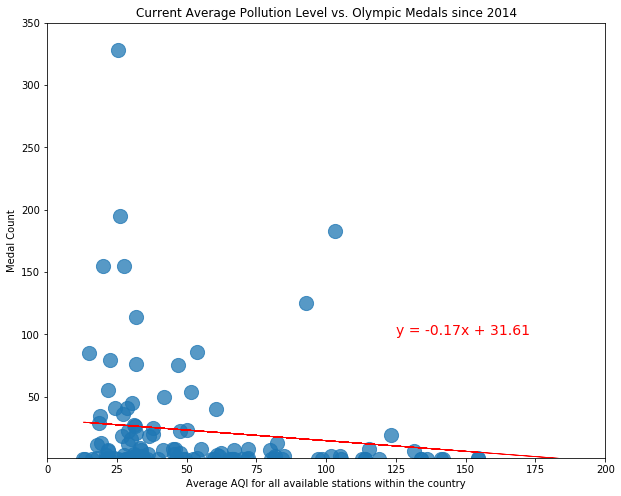

In [70]:
# plot the Olympic Medal Totals versus Polution

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(pollution_df.pollution, pollution_df.MedalCount)
regress_values = pollution_df.pollution * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(10,8))
plt.scatter(pollution_df.pollution,pollution_df.MedalCount,s=200,alpha=0.75)
plt.plot(pollution_df.pollution,regress_values,"r-",lw=.8)
plt.annotate(line_eq,(125,100),fontsize=14,color="red")

plt.title("Current Average Pollution Level vs. Olympic Medals since 2014")
plt.xlabel("Average AQI for all available stations within the country")
plt.ylabel("Medal Count")
plt.xlim(0,200)
plt.ylim(0.8,350)

print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.savefig("pngs/9 - Average Current Pollution Level vs Recent Olympic Performance.png")

plt.show()

# 4. Comparison of Athletes and their Sports [rename]

---
## 4.1 Athlete Weights and Heights <br> <font size=2 color=lightgrey>by Mrudula</font>

In [4]:
#Obtain min, max, median values for Weight and Height
male_df = raw_olympics_df[raw_olympics_df.Sex=='M']
sport_weight_height_metrics = male_df.groupby(
    ['Sport'])['Weight','Height'].agg(['min','max','mean'])

sport_weight_height_metrics.dropna(how='all')

NameError: name 'raw_olympics_df' is not defined

#### Athlete Weights

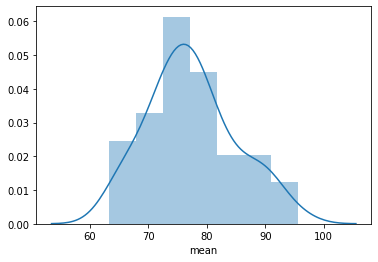

In [72]:
#Plot mean values of weight on a histogram
sns.distplot(sport_weight_height_metrics.Weight.dropna()['mean'])

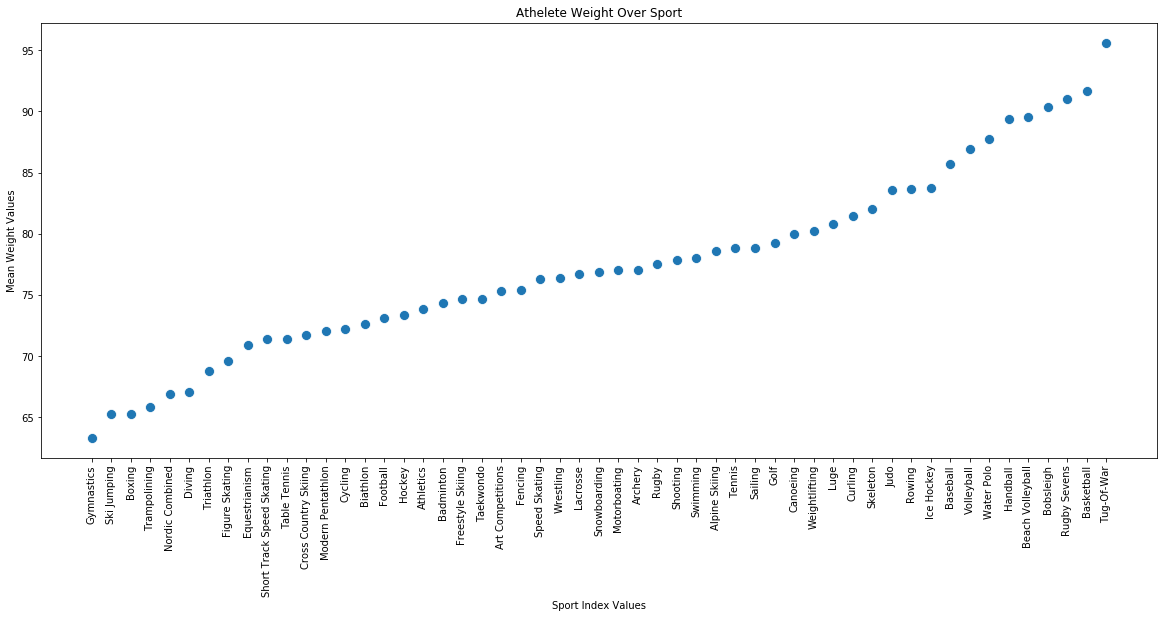

In [73]:
#Create a variable and store all the  weight values
means = list(sport_weight_height_metrics.Weight.dropna()['mean'])

#create a variable and store all the index values
sports = list(sport_weight_height_metrics.Weight.dropna().index)

plot_data = sorted(zip(sports, means), key = lambda x:x[1])
plot_data_dict = {
    'x' : [i for i, _ in enumerate(plot_data)],
    'y' : [v[1] for i, v in enumerate(plot_data)],
    'group' :  [v[0] for i, v in enumerate(plot_data)]
}

plt.figure(0,(20,8))

#Plot a scatter plot for x,y values
sns.scatterplot(data = plot_data_dict, x = 'x' , y = 'y', s=100)
#set the x-ticks to be the respective sports
plt.xticks(np.arange(0,53),plot_data_dict['group'], rotation=90)
#set title for the fig
plt.title('Athelete Weight Over Sport')
# Set x-axis label
plt.xlabel('Sport Index Values')
# Set y-axis label
plt.ylabel('Mean Weight Values')
plt.show()

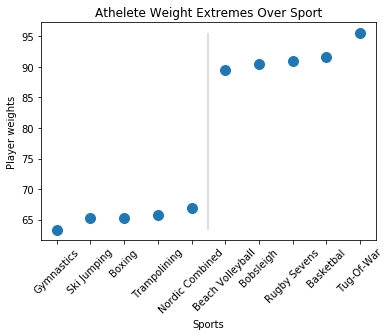

In [78]:
sports_w_extremes = ["Gymnastics", "Ski Jumping", "Boxing", "Trampolining", "Nordic Combined", "Beach Volleyball", "Bobsleigh", "Rugby Sevens", "Basketbal", "Tug-Of-War"]
weight_extremes = [63.34360475924893, 65.24588053553038, 65.29627979505457, 65.83783783783784, 66.9095595126523, 89.51282051282051, 90.38738521024649, 91.00662251655629, 91.68352893565358, 95.61538461538461]

# Plot the line for heaviest weights vs Sports
plt.scatter(sports_w_extremes, weight_extremes, s=100)
plt.title("Athelete Weight Extremes Over Sport")
plt.xlabel("Sports")
plt.ylabel("Player weights")
plt.vlines(4.5, weight_extremes[0], weight_extremes[9], color='lightgrey')
plt.xticks(rotation=45)

plt.savefig("pngs/10 - Athlete Weight Extremes by Sport.png")

plt.show()

#### Athlete Heights

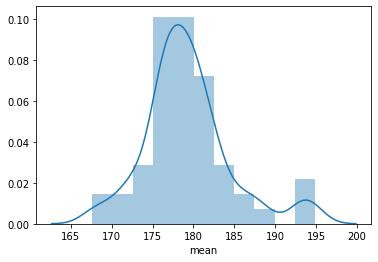

In [77]:
#Plot mean values of height on a histogram
sns.distplot(sport_weight_height_metrics.Height.dropna()['mean'])

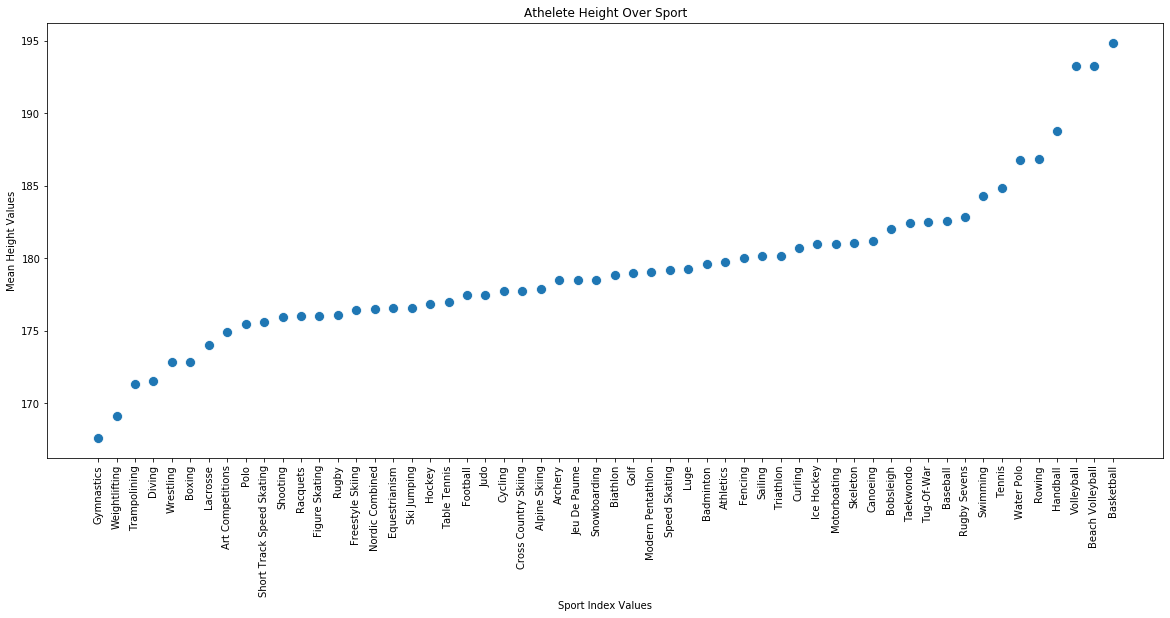

In [75]:
#Create a variable and store all the height values
means = list(sport_weight_height_metrics.Height.dropna()['mean'])

#create a variable and store all the index values
sports = list(sport_weight_height_metrics.Height.dropna().index)

plot_data = sorted(zip(sports, means), key = lambda x:x[1])
plot_data_dict = {
    'x' : [i for i, _ in enumerate(plot_data)],
    'y' : [v[1] for i, v in enumerate(plot_data)],
    'group' :  [v[0] for i, v in enumerate(plot_data)]
}

plt.figure(0,(20,8))

#Plot a scatter plot for x,y values
sns.scatterplot(data = plot_data_dict, x = 'x' , y = 'y', s=100)
#set the x-ticks to be the respective sports
plt.xticks(np.arange(0,56),plot_data_dict['group'], rotation=90)
#set title for the fig
plt.title('Athelete Height Over Sport')
# Set x-axis label
plt.xlabel('Sport Index Values')
# Set y-axis label
plt.ylabel('Mean Height Values')
plt.show()

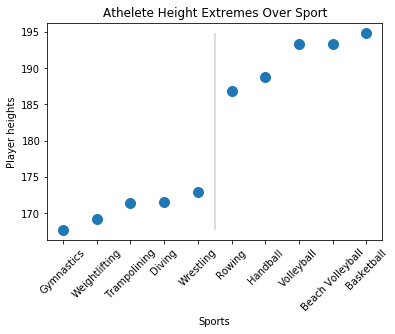

In [79]:
sports_h_extremes = ["Gymnastics", "Weightlifting", "Trampolining", "Diving", "Wrestling", "Rowing", "Handball", "Volleyball", "Beach Volleyball", "Basketball"]
height_extremes = [167.6444383959354, 169.1530612244898, 171.3684210526316, 171.55535224153707, 172.87068623562078, 186.88269794721407, 188.77837311251827, 193.26565995525726, 193.29090909090908, 194.87262357414448]

# Plot the line for heaviest weights vs Sports
plt.scatter(sports_h_extremes, height_extremes,s=100)
plt.title("Athelete Height Extremes Over Sport")
plt.xlabel("Sports")
plt.ylabel("Player heights")
plt.vlines(4.5, height_extremes[0], height_extremes[9], color='lightgrey')
plt.xticks(rotation=45)

plt.savefig("pngs/11 - Athlete Height Extremes by Sport.png")

plt.show()

Text(0, 0.5, 'Average build Values')

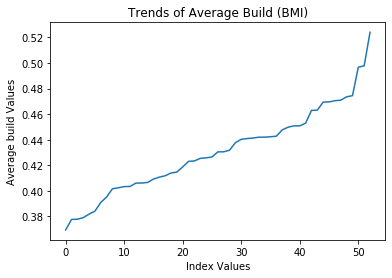

In [80]:
#Create a variable to store all the mean values of height, weight and find the avergae build 
mean_heights = sport_weight_height_metrics.Height.dropna()['mean']
mean_weights = sport_weight_height_metrics.Weight.dropna()['mean']

#obtain the avg build of each player
avg_build = mean_weights/mean_heights
avg_build.sort_values(ascending = True)
builds = list(avg_build.sort_values(ascending = True))

#Create a line plot for x,y values
plot_dict = {'x':[i for i,_ in enumerate(builds)],'y':builds}
sns.lineplot(data=plot_dict, x='x', y='y')

#set title for the fig
plt.title('Trends of Average Build (BMI)')
# Set x-axis label
plt.xlabel('Index Values')
# Set y-axis label
plt.ylabel('Average build Values')

---
## 4.2 Althete Performance at the Olympics <br> <font size=2 color=lightgrey>by Warren</font>


#### Number of events an athlete has participated in

In [81]:
# Let's take a dive into the individual athletes who have competed at the Olympics
olympics_groupedby_athlete = olympics_df.groupby('Name')
# Count the number of events an athlete has participated in
event_count = olympics_groupedby_athlete.count()['Sex'].sort_values(ascending=False)
# Who has participated the most?
event_count.head(10)

Name
Robert Tait McKenzie                58
Heikki Ilmari Savolainen            39
Joseph "Josy" Stoffel               38
Ioannis Theofilakis                 36
Takashi Ono                         33
Jean Lucien Nicolas Jacoby          32
Alfrd (Arnold-) Hajs (Guttmann-)    32
Alexandros Theofilakis              32
Andreas Wecker                      32
Alfred James Munnings               31
Name: Sex, dtype: int64

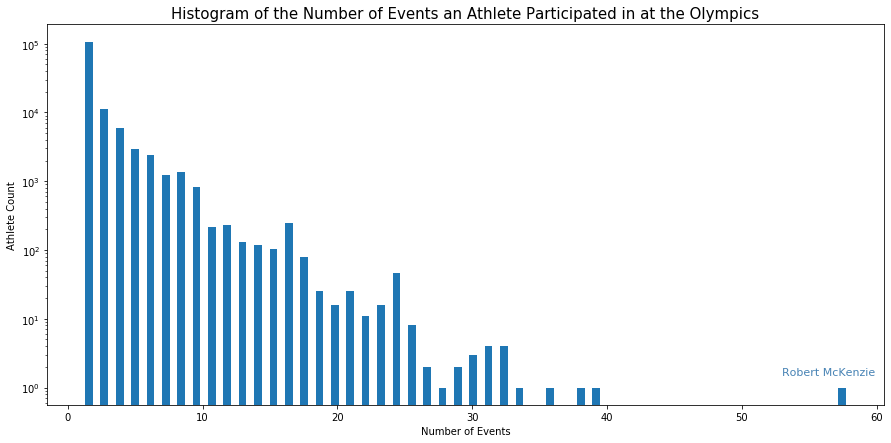

In [82]:
plt.figure(0,(15,7))
plt.hist(event_count, bins=50, log=True, rwidth=0.5)
plt.annotate('Robert McKenzie',(53,1.5),size=11,color='steelblue')
plt.xlabel("Number of Events")
plt.ylabel("Athlete Count")
plt.title('Histogram of the Number of Events an Athlete Participated in at the Olympics', size=15)
plt.show()

**Fun Fact:** the first half of the 20th Century saw art competitons in the Olympics. It should be fairly obvious that Robert McKenzie is an outlier in the number of Olympic competitions he has been apart of, and that's because he wasn't an athlete at all, he was a sculptor. Most all of the other top competitors were gymnists, being able to compete in many different competitions at every Games.

### Number of events an athlete *who has medalled* has participated in

In [83]:
# Start by making a df that we can operate on
olympics_groupedby_athlete_df = pd.DataFrame(olympics_groupedby_athlete.count())
# Then we filter out any athletes who haven't medalled
medalled_olymians_df = olympics_groupedby_athlete_df.loc[olympics_groupedby_athlete_df['Medal'] > 0]
# and follow the same steps as before
medalled_groupedby_athlete = medalled_olymians_df.groupby('Name')
medalled_event_count = medalled_groupedby_athlete.max()['Sex'].sort_values(ascending=False)
medalled_event_count.head(10)

Name
Robert Tait McKenzie                58
Heikki Ilmari Savolainen            39
Ioannis Theofilakis                 36
Takashi Ono                         33
Alfrd (Arnold-) Hajs (Guttmann-)    32
Jean Lucien Nicolas Jacoby          32
Alexandros Theofilakis              32
Andreas Wecker                      32
Alfred August "Al" Jochim           31
Michael Fred Phelps, II             30
Name: Sex, dtype: int64

As expected, many of the same names appear on this tailored list because surely if an athlete aprticipates in a bunch of competitions he/she will most likely have medalled. But there is one name missing...

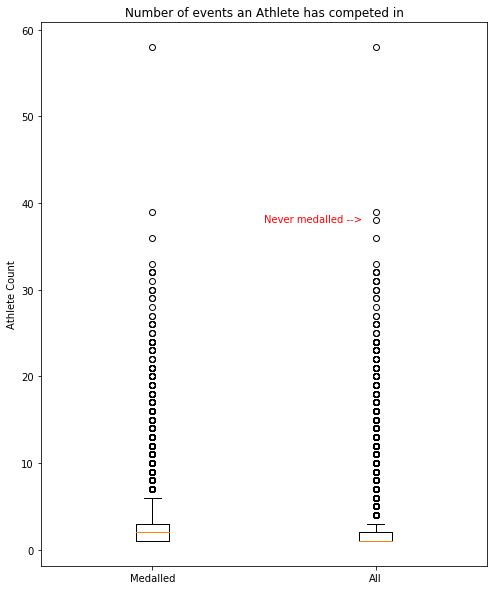

In [84]:
# Lets make a box-and-whisker plot to show all of the outliers 
plt.figure(0,(8,10))
plt.title('Number of events an Athlete has competed in')
plt.ylabel('Athlete Count')
plt.boxplot([medalled_event_count, event_count])
plt.xticks([1,2],['Medalled', 'All'])

# And here we see someone who competed in 38 events yet never once medalled
plt.annotate('Never medalled -->',(1.5,37.75),fontsize=10,color="red")
plt.show()

#### So who is Joseph "Josy" Stoffel?  
* Born on June 27th, 1928 (currently age 91) he went to 5 Summer Olympic games between 1948 to 1964.  From age 20 to 36 he competed on behalf of Luxembourg in 7-8 Gymnastics events per trip. Unfortunately he did not finish within the top three in any of his 38 competitions. But not for nothing, Stoffel dominated the domestic scene, and won the Luxembourgian national gymnastics championships for sixteen straight years, from 1949 until 1964. 

---
## 4.3 Sports lifespans at the Olympics <br> <font size=2 color=lightgrey>by Warren</font>

In [85]:
#Calculate the max year of each sport
sport_max_year = male_df.groupby('Sport').Year.agg(['min','max'])['max']
sport_min_year = male_df.groupby('Sport').Year.agg(['min','max'])['min']

# Concatenate your pd.Series into a df
min_and_max = pd.concat([sport_min_year, sport_max_year], axis=1)
min_and_max['max'] = min_and_max['max'].astype(float)
min_and_max['min'] = min_and_max['min'].astype(float)

# Here we add 4 years to the duration in assumptions that a sport maintains its Olympic status 
#  until the next Olympic Games of the same season is held witout said sport
min_and_max['duration'] = min_and_max['max']-min_and_max['min']+4 

# Let's take a look
min_and_max.sort_values('duration')

,min,max,duration
Sport,,,
Aeronautics,1936.0,1936.0,4.0
Rugby Sevens,2016.0,2016.0,4.0
Roque,1904.0,1904.0,4.0
Racquets,1908.0,1908.0,4.0
Motorboating,1908.0,1908.0,4.0
...,...,...,...
Weightlifting,1896.0,2016.0,124.0
Shooting,1896.0,2016.0,124.0
Athletics,1896.0,2016.0,124.0


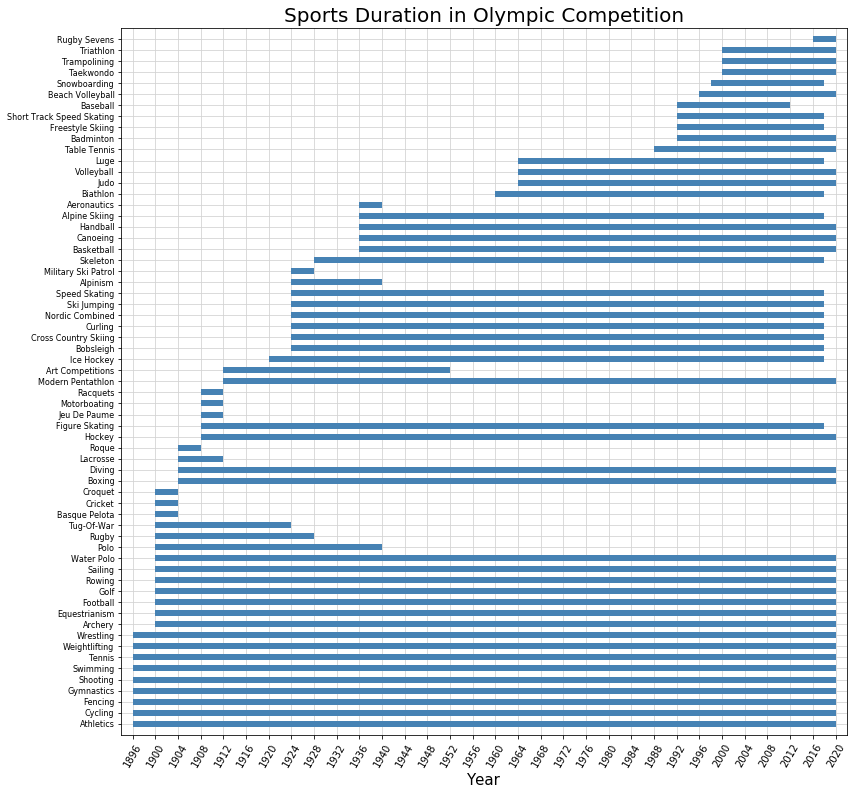

In [86]:
# We now want to make a chart which displays how long each sport maintained its Olympic status

# Start by sorting the first date the sport appeared so the newest sports are on top,
#  and a secondary sort for duration for aesthetics, making the chart flow from shortest lines to longest 
min_and_max_df = min_and_max.sort_values(['min','duration'],ascending=[True, False]).reset_index()

# Now we are ready to make a for-loop to plot each bar (hline) on our graph
plt.figure(0,(13,13))
for i in list(range(0,len(min_and_max_df))):
    plt.hlines(i, min_and_max_df.loc[i]['min'], min_and_max_df.loc[i]['max']+4, color='steelblue', lw=6)

plt.xticks(list(range(1896,2024,4)),rotation=60)
plt.yticks(list(range(0,len(min_and_max_df))), min_and_max_df.Sport, size=8)
plt.xlim(min_and_max_df['min'].min()-2,min_and_max_df['max'].max()+6)
plt.ylim(-1,len(min_and_max_df))
plt.title('Sports Duration in Olympic Competition', size=20)
plt.xlabel('Year', size=15)
plt.grid(color='lightgrey')

plt.savefig("pngs/12 - Olympic Sport History Over Time.png")

plt.show()

# 5. Conculsions

*List all major conculsions here*